# DNA Methylation Differential Analysis with `dmeth`

### Tumor-Normal Comparison Using TCGA Illumina HumanMethylation450K Data

This notebook shows a complete workflow using **`dmeth`**:

1. Study design & platform planning
2. Loading methylation data
3. Quality control (QC)
4. Differential methylation modeling
5. Visualization & diagnostics
6. Downstream analyses

**dmeth version** printed below for reproducibility.

## Reproducibility

In [1]:
# Reproducibility & versioning
import random
import numpy as np
import dmeth

random.seed(42)
np.random.seed(42)

print("dmeth version:", dmeth.__version__)

dmeth version: 0.2.0


## 1. Import Required Libraries

The following libraries are used for data handling, visualization, web requests, and the full `dmeth` pipeline, including preprocessing, QC, differential analysis, annotation, and downstream interpretation.

In [2]:
# Core stack
import pandas as pd
from pathlib import Path
import xenaPython as xena
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# dmeth modules
from dmeth.io.readers import load_methylation_data, load_processed_data
from dmeth.io.writers import save_processed_data, export_results

from dmeth.core.planner import (
    list_platforms,
    list_designs,
    get_design,
    get_platform,
    calculate_sample_size,
    estimate_total_cost,
    estimate_study_timeline,
    get_cost_components,
    get_platform_by_budget,
    update_platform_cost,
    update_regional_pricing,
)

from dmeth.core.data_preprocessing import (
    qc_sample_level,
    qc_cpg_level,
    filter_low_variance_cpgs,
    normalize_methylation_highperf,
    batch_correction_combat,
)

from dmeth.core.analysis.preparation import (
    filter_cpgs_by_missingness,
    impute_missing_values,
    filter_min_per_group,
)

from dmeth.core.analysis.validation import (
    build_design,
    validate_contrast,
    validate_alignment,
    check_analysis_memory,
)

from dmeth.core.analysis.core_analysis import fit_differential_chunked

from dmeth.core.analysis.postprocessing import (
    get_significant_cpgs,
    summarize_differential_results,
)

from dmeth.core.downstream.downstream_stats import (
    adjust_pvalues,
    stouffer_combined_pvalue,
    compute_delta_beta,
    compute_effect_size,
    filter_dms,
    find_dmrs_by_sliding_window,
    summarize_regions,
    compute_dms_reproducibility,
)

from dmeth.core.downstream.annotation import (
    map_dms_to_genes,
    gene_set_enrichment,
    liftover_coordinates,
    pathway_methylation_scores,
    correlate_methylation_expression,
)

from dmeth.core.downstream.deconvolution import estimate_cell_composition

from dmeth.core.downstream.signature import (
    select_signature_panel,
    model_dms_for_prediction,
    validate_signature,
)

from dmeth.utils.plotting import (
    plot_stage,
    visualize_dms,
    plot_volcano,
    plot_pvalue_qq,
    pca_plot,
    plot_shrinkage_diagnostics,
    plot_mean_difference,
    pvalue_histogram,
    methylation_expression_heatmap,
)

/var/mobile/Containers/Data/Application/C9510E6C-036B-41C5-A78F-970160959C59/Library/lib/python3.11/site-packages/xenaPython/__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


[2025-12-01 16:42:35] [WARNING] dmeth: toml not installed. Install with: pip install toml
[2025-12-01 16:42:36] [WARNING] dmeth: psutil module not installed, `check_analysis_memory` is unavailable.
[2025-12-01 16:42:36] [WARNING] dmeth: Numba not installed. Feature fitting will be slower.
[2025-12-01 16:42:36] [WARNING] dmeth: IntervalTree not installed. Using distance-based fallback.
[2025-12-01 16:42:37] [WARNING] dmeth: umap-learn not installed. UMAP QC embedding disabled.


## 2. Study Planning

#### 2.1 Available DNA Methylation Platforms

`list_platforms()` returns all default DNA methylation platforms supported in `dmeth`, spanning both array-based and sequencing-based technologies.

For each platform, the function reports CpG coverage, per-sample cost, and whether the platform is recommended for general use. Custom platforms can also be added via `add_custom_platform()`, `load_file()`, or similar extension functions.

In [3]:
platforms = list_platforms()

platforms[["name", "n_cpgs", "cost_per_sample", "recommended"]].style.format(
    {"n_cpgs": "{:,}", "cost_per_sample": "${:,.2f}"}
)

[2025-12-01 16:42:37] [INFO] dmeth: Loaded sidecar config from /var/mobile/Containers/Data/Application/C9510E6C-036B-41C5-A78F-970160959C59/Library/lib/python3.11/site-packages/dmeth/config/defaults.json


#### 2.2 List All Available Experimental Designs

`list_designs()` returns all supported experimental designs in `dmeth`.

Each design includes a description of its intended use case, number of groups, whether samples are paired, design complexity, recommended minimum sample size, and the corresponding analysis framework.

In [4]:
designs = list_designs()

designs

name  \
two_group                        Two-Group Comparison   
paired                          Paired/Matched Design   
multi_group                    Multi-Group Comparison   
factorial_2x2                    2×2 Factorial Design   
time_series                  Longitudinal Time Series   
case_control_matched             Matched Case-Control   
discovery_replication    Discovery-Replication Design   
cell_type_deconv       Cell Type Heterogeneity Design   

                                                             description  \
two_group              Compare two independent groups (e.g., case vs ...   
paired                 Compare matched or repeated-measures samples f...   
multi_group                     Compare three or more independent groups   
factorial_2x2          Two factors with two levels each (e.g., diseas...   
time_series            Multiple timepoints measured in same subjects ...   
case_control_matched   Cases matched to controls on key confounders (...   
discovery_replication  Two-stage design with discovery cohort and ind...   
cell_type_deconv       Bulk tissue with cell type proportion estimati...   

                       n_groups  paired    complexity  min_n_recommended  \
two_group                     2   False        Simple                 15   
paired                        2    True        Simple                 12   
multi_group                   3   False  Intermediate                 12   
factorial_2x2                 4   False  Intermediate                 10   
time_series                   1    True      Advanced                  8   
case_control_matched          2    True  Intermediate                 20   
discovery_replication         2   False      Advanced                 30   
cell_type_deconv              2   False      Advanced                 25   

                       power_adjustment  \
two_group                          1.00   
paired                             0.71   
multi_group                        1.15   
factorial_2x2                      1.25   
time_series                        0.65   
case_control_matched               0.85   
discovery_replication              1.40   
cell_type_deconv                   1.30   

                                                         analysis_method  \
two_group                Linear regression with age/sex/batch covariates   
paired                 Linear mixed model or paired analysis with sub...   
multi_group            ANOVA-style linear models with post-hoc contrasts   
factorial_2x2                       Two-way ANOVA with interaction terms   
time_series            Linear mixed models with time as continuous or...   
case_control_matched   Conditional logistic regression or stratified ...   
discovery_replication  Multi-stage testing with replication-based val...   
cell_type_deconv       Cell type deconvolution (e.g., IDOL, EpiDISH) ...   

                                                            example_uses  
two_group              [Cancer vs normal tissue, Disease cases vs hea...  
paired                 [Pre-treatment vs post-treatment in same patie...  
multi_group            [Multiple disease subtypes, Dose-response stud...  
factorial_2x2          [Disease status by sex interactions, Treatment...  
time_series            [Aging studies with multiple timepoints, Disea...  
case_control_matched   [Epidemiological case-control studies, Matched...  
discovery_replication  [EWAS with replication cohort, Biomarker disco...  
cell_type_deconv       [Whole blood with immune cell correction, Brai...

#### 2.3 Inspect a Specific Platform and Design

The `get_platform()` function retrieves detailed specifications for a selected DNA methylation platform, while `get_design()` provides the characteristics of a chosen experimental design template.  

This example inspects:

- **Platform:** 450K array, containing 485,512 CpG probes  
- **Design:** Paired/Matched Design - appropriate for studies comparing repeated measures or matched samples

In [5]:
cfg_450K = get_platform("450K")
case_control_cfg = get_design("paired")

print(
    f"\nPlatform: 450K with {cfg_450K['n_cpgs']:,} "
    f"probes\nDesign: {case_control_cfg['name']}"
)


Platform: 450K with 485,512 probes
Design: Paired/Matched Design


#### 2.4 Filter Platforms by Budget

Using `get_platform_by_budget()`, we can identify platforms compatible with a defined cost ceiling. This facilitates rational study planning by balancing coverage, technology type, and per-sample expenditure.

In this example, platforms with a cost of **less than \$350 per sample** are selected.  

In [6]:
budget_platforms = get_platform_by_budget(max_cost_per_sample=350)

print("Platforms within budget:")
budget_platforms.style.format(
    {"n_cpgs": "{:,}", "cost_per_sample": "${:,.2f}", "dna_required_ng": "{:,.2f}"}
)

Platforms within budget:


The resulting table shows platforms meeting the budget criteria, along with relevant details such as:

- Manufacturer and platform name  
- CpG coverage and genomic regions covered
- Cost per sample and processing time
- DNA input requirements
- Release year
- Current status (e.g., Mature, Research use, Discontinued)
- Recommendation flags and notes on usage

#### 2.5 Update Cost Assumptions

`dmeth` allows updating platform cost estimates to reflect regional differences or discounts.  
For example, we can account for:

- A 20% increase in experimental costs in West Africa using `update_regional_pricing()`; or 
- A 5% reduction in Illumina 450K per-sample cost using `update_platform_cost()`

These adjustments help generate more accurate budget estimates for study planning.

In [7]:
update_regional_pricing(multiplier=1.20, region="West Africa demo")
update_platform_cost(platform_id="450K", new_cost=cfg_450K["cost_per_sample"] * 0.95)

[2025-12-01 16:42:37] [INFO] dmeth: Applied 1.20x pricing multiplier for West Africa demo
[2025-12-01 16:42:37] [INFO] dmeth: Updated cost for 450K: $304.00


#### 2.6 Cost Components for Transparency

To facilitate transparent study budgeting, `dmeth` allows inspection of the detailed cost components for a given platform. This includes both mandatory and optional expenses associated with DNA methylation experiments, such as DNA extraction, bisulfite conversion, quality control, bioinformatics processing, and project management.  

For example, the cost breakdown for the 450K array can be retrieved using `get_cost_components()`.

In [8]:
components = get_cost_components(platform="450K", include_optional=True)

print("Cost components (450K):")
pd.DataFrame(components).T.reset_index().rename(
    columns={"index": "component"}
).style.format({"cost": "${:,.2f}"})

Cost components (450K):


#### 2.7 Sample Size Planning

Accurate estimation of sample size is critical to ensure sufficient statistical power in differential methylation studies. `calculate_sample_size()` computes the number of samples required per group and overall, given the study design, methylation platform, anticipated effect size, significance level, desired power, and multiple testing correction method.  

In this example, a paired 450K array study targeting an effect size of 0.8 with 90% power requires 14 samples per group, for a total of 28 samples. This ensures adequate power to detect the specified effect size while controlling the false discovery rate (FDR).

In [9]:
sample_size = calculate_sample_size(
    design_id="paired",
    platform_id="450K",
    effect_size=0.8,
    alpha=0.05,  # nominal alpha (before correction)
    power=0.90,
    mcp_method="FDR",
)

print(
    f"\nRecommended per-group: {sample_size['n_per_group']} | "
    f"total: {sample_size['total_samples']}"
)

[2025-12-01 16:42:37] [INFO] dmeth: Sample size calc: design=paired, platform=450K, effect_size=0.80, alpha=0.050, alpha_eff=5.000e-02, paired=True, n_per_group=14, total=28

Recommended per-group: 14 | total: 28


#### 2.8 Estimate Total Study Cost

`dmeth` can estimate the total study cost by aggregating all relevant components for the planned sample size and selected platform. This includes both mandatory and optional expenses, such as DNA extraction, bisulfite conversion, QC, bioinformatics processing, and project management.

For example, estimating costs for a paired 450K array study with 28 total samples using `estimate_total_cost()`:

In [10]:
study_cost = estimate_total_cost(
    n_samples=sample_size["total_samples"],
    platform_id="450K"
)

total = study_cost["total"]

print(f"\nTotal estimated cost: ${total:,.2f}\n")
study_cost["components"].style.format({"cost": "${:,.2f}"})

[2025-12-01 16:42:37] [INFO] dmeth: Total cost calc: n_samples=28, platform_id=450K, total_cost=25799.188672, per_sample_cost=921.3995954285714

Total estimated cost: $25,799.19



The total estimated cost for this study is **\$28,613.55**, broken down by component. This transparent breakdown allows informed budgeting and identification of optional or adjustable cost components.

## 3. Load Data

This section demonstrates fetching TCGA LUAD clinical and methylation data for analysis. We select paired tumor–normal samples, retrieve beta values for a subset of CpG probes, and load probe annotations for downstream analysis.

#### 3.1 Fetch Clinical Data

We retrieve clinical metadata from the [Xena Hub](https://tcga.xenahubs.net) for TCGA LUAD.

- Patient identifiers are extracted from sample barcodes.  
- Samples are classified as **tumor** or **normal** based on TCGA sample type codes.  
- Only patients with paired tumor–normal samples are selected for this demonstration.

In [11]:
HUB = "https://tcga.xenahubs.net"

# Clinical data fetch
print("Fetching clinical data...")
clin_name = "TCGA.LUAD.sampleMap/LUAD_clinicalMatrix"

fields = xena.dataset_field(HUB, clin_name)
samples_clin = xena.dataset_samples(HUB, clin_name, None)

clin_vals = xena.dataset_probe_values(
    HUB,
    clin_name,
    samples_clin,
    fields
)
field_names, values = clin_vals

pheno = pd.DataFrame(
    np.array(values).T,
    index=samples_clin,
    columns=field_names
)
pheno["patient_id"] = pheno.index.str[:12]


# TCGA sample type decoding
def sample_type_from_barcode(barcode):
    """
    TCGA barcode positions 14–15 = sample type code:
    01 = Primary Tumor
    11 = Solid Tissue Normal
    """
    code = barcode[13:15]
    if code == "01":
        return "tumor"
    elif code == "11":
        return "normal"
    return "other"


pheno["group"] = pheno.index.map(sample_type_from_barcode)
pheno = pheno[pheno["group"] != "other"]

paired_patients = pheno.groupby("patient_id")["group"].nunique()
paired_patients = paired_patients[paired_patients == 2].index

rng = np.random.default_rng(42)
selected_patients = rng.choice(paired_patients, size=100, replace=False)

pheno_paired = pheno[pheno["patient_id"].isin(selected_patients)].copy()

print(f"✓ Selected {len(selected_patients)} paired patients")
print(f"✓ Total samples: {len(pheno_paired)}")
print(pheno_paired["group"].value_counts())

Fetching clinical data...
✓ Selected 100 paired patients
✓ Total samples: 200
group
tumor     100
normal    100
Name: count, dtype: int64


#### 3.2 Fetch Methylation Data

We fetch beta values from the HumanMethylation450 dataset.

- Batched retrieval avoids transfer failures for large matrices.  
- Only a subset of 50,000 probes is loaded for demonstration.  
- The final beta matrix is oriented as **probes × samples**.

In [13]:
# Methylation data fetch (batched to avoid Xena chunked-transfer failures)
# Fetch and clean probes
meth_dataset_name = "TCGA.LUAD.sampleMap/HumanMethylation450"
all_probes = xena.dataset_field(HUB, meth_dataset_name)

# Sample 50,000 unique probes without replacement
n_sample = min(
    50000,  # increase/decrease as required
    len(all_probes)
)
probes = np.random.choice(all_probes, size=n_sample, replace=False).tolist()
samples = pheno_paired.index.tolist()

print(f"\nFetching {len(probes):,} probes for {len(samples):,} samples...")


def fetch_in_batches(hub, dataset, samples, probes, batch_size=2000):
    """
    Xena returns either:
      - (probe_ids, values)
      - values_only
    depending on endpoint and arguments.

    This normalizes both into (probe_ids, values).
    """
    all_probe_ids = []
    all_values = []

    for i in range(0, len(probes), batch_size):
        batch = probes[i : i + batch_size]
        print(f"  • Batch {i+1:,}-{i+len(batch):,}")

        result = xena.xenaQuery.dataset_probe_values(
            hub,
            dataset,
            samples,
            batch
        )

        # Normalize return type
        if isinstance(result, tuple) and len(result) == 2:
            probe_ids, vals = result
        else:
            # Xena returned only the values
            probe_ids = batch
            vals = result

        # Sanity convert
        vals = np.array(vals)

        # Append
        all_probe_ids.extend(probe_ids)
        all_values.append(vals)

    # Combine batches into a full matrix
    values = np.vstack(all_values)
    return all_probe_ids, values


# Perform batched fetch
probe_ids, values = fetch_in_batches(
    HUB,
    meth_dataset_name,
    samples,
    probes,
    batch_size=2000
)

values = np.array(values)

# Orientation check (same as original)
if values.shape[0] == len(samples) and values.shape[1] == len(probes):
    beta = pd.DataFrame(values, index=samples, columns=probes).T
elif values.shape[0] == len(probes) and values.shape[1] == len(samples):
    beta = pd.DataFrame(values, index=probes, columns=samples)
else:
    raise ValueError(
        f"Unexpected matrix shape {values.shape}. "
        "Expected either (samples × probes) or (probes × samples)."
    )

beta = beta.apply(pd.to_numeric, errors="coerce")

print(f"✓ Beta matrix shape: {beta.shape}")
print(
    f"✓ Missing values: {beta.isna().sum().sum():,} "
    f"({100 * beta.isna().sum().sum() / beta.size:.1f}%)"
)


Fetching 50,000 probes for 200 samples...
  • Batch 1-2,000
  • Batch 2,001-4,000
  • Batch 4,001-6,000
  • Batch 6,001-8,000
  • Batch 8,001-10,000
  • Batch 10,001-12,000
  • Batch 12,001-14,000
  • Batch 14,001-16,000
  • Batch 16,001-18,000
  • Batch 18,001-20,000
  • Batch 20,001-22,000
  • Batch 22,001-24,000
  • Batch 24,001-26,000
  • Batch 26,001-28,000
  • Batch 28,001-30,000
  • Batch 30,001-32,000
  • Batch 32,001-34,000
  • Batch 34,001-36,000
  • Batch 36,001-38,000
  • Batch 38,001-40,000
  • Batch 40,001-42,000
  • Batch 42,001-44,000
  • Batch 44,001-46,000
  • Batch 46,001-48,000
  • Batch 48,001-50,000
✓ Beta matrix shape: (50000, 200)
✓ Missing values: 6,020,248 (60.2%)


### 3.3 Fetch Probe Annotation

Probe annotations are downloaded from [Illumina](https://support.illumina.com/downloads/infinium_humanmethylation450_product_files.html) and reindexed to match the beta matrix. These annotations provide genomic locations and features for each CpG site.

In [14]:
# Annotation fetch
print("\nFetching CpG probe annotation data...")

ann_url = (
    "https://webdata.illumina.com/downloads/productfiles/"
    "humanmethylation450/humanmethylation450_15017482_v1-2.csv"
)

ann = pd.read_csv(ann_url, skiprows=7, low_memory=False)
ann = ann.set_index("IlmnID").reindex(beta.index)

print(f"✓ Annotation dataframe shape: {ann.shape}")


Fetching CpG probe annotation data...
✓ Annotation dataframe shape: (50000, 32)


### 3.4 Load Data into `dmeth` Container

Beta matrix, phenotype table, and probe annotation can be loaded into a `dmeth` `MethylationData` container using `load_methylation_data()`. This container standardizes data structure for downstream preprocessing, QC, and differential analysis.

The container provides convenient access to methylation (`M`), phenotype (`pheno`), and annotation (`ann`) data.

In [15]:
data = load_methylation_data(beta, pheno_paired, ann)

print(
    f"\nLoaded {data.M.shape[0]:,} CpGs × {data.M.shape[1]} samples "
    "(raw matrix is beta-values)"
)

[2025-12-01 16:57:51] [INFO] dmeth: Loaded 200 samples, 50000 CpGs.

Loaded 50,000 CpGs × 200 samples (raw matrix is beta-values)


## 4. Preprocessing & QC

Before performing differential methylation analysis, it is essential to perform quality control (QC) at both the CpG and sample levels. This ensures that probes or samples with excessive missing values or unreliable measurements do not confound downstream analyses.

#### 4.1 CpG-Level QC

##### 4.1.1 Filter by Missingness

`qc_cpg_level()` filters probes based on missingness:

- **max_missing_fraction**: maximum allowed fraction of missing values per probe (here, 60%)
- **drop_sex_chr**: remove probes located on sex chromosomes to avoid sex-specific bias  
- **chr_col**: column in annotation containing chromosome information

In [16]:
data = qc_cpg_level(
    data,
    max_missing_fraction=0.6,
    drop_sex_chr=True,
    chr_col="CHR"
)

cpg_qc_flag = data.meta["qc"]["cpg_missing"]["flagged"]
print(f"\nRemoved {cpg_qc_flag:,} probes with excessive missingness")

[2025-12-01 16:57:51] [INFO] dmeth: CpG level QC:threshold=0.6, sex_chr_dropped=True, flagged=10437

Removed 10,437 probes with excessive missingness


##### 4.1.2 Remove Low-Variance Probes

Probes with very low variance across samples are unlikely to be biologically informative for differential methylation analysis. We remove the bottom 10% of probes by variance using `filter_low_variance_cpgs()` to focus on CpGs that show meaningful variability.

In [17]:
data = filter_low_variance_cpgs(data=data, min_percentile=10.0)

variance_qc_flag = data.meta["qc"]["low_variance_removed"]
print(f"\nRemoved bottom 10% ({variance_qc_flag:,}) probes by variance")

[2025-12-01 16:57:51] [INFO] dmeth: low_variance_removed: 3957

Removed bottom 10% (3,957) probes by variance


#### 4.2 Sample-Level QC

`qc_sample_level()` removes samples with excessive missing values to ensure robust downstream analysis.

Here, we apply the following filters:

- **max_missing_fraction**: samples with more than 60% missing beta values are removed  
- **remove_samples**: automatically drop flagged samples from the container

In [18]:
data = qc_sample_level(data, max_missing_fraction=0.6, remove_samples=True)

sample_qc_flag = data.meta["qc"]["sample_missing"]["flagged"]
print(f"\nRemoved {sample_qc_flag:,} samples with excessive missingness")

[2025-12-01 16:57:51] [INFO] dmeth: Sample level QC: threshold=0.6, flagged=102, removed=102

Removed 102 samples with excessive missingness


#### 4.3 Select Required Paired Patients

To adhere to the planned study design and power calculations, we select the required number of tumor–normal pairs:

1. Identify patients with both tumor and normal samples.  
2. Randomly select `sample_size["n_per_group"]` pairs according to study planning (here, 14 pairs).  
3. Subset the `MethylationData` container to retain only these paired samples.

In [19]:
paired_patients = data.pheno.groupby("patient_id")["group"].nunique()
paired_patients = paired_patients[paired_patients == 2].index

rng = np.random.default_rng(42)
selected_patients = rng.choice(
    paired_patients,
    size=sample_size["n_per_group"],
    replace=False
)

data.pheno = data.pheno[data.pheno["patient_id"].isin(selected_patients)].copy()
data.M = data.M[data.M.columns.intersection(data.pheno.index)]

print(f"✓ Selected {len(selected_patients)} paired patients")
print(f"✓ Total samples: {len(data.pheno)}")
print(data.pheno["group"].value_counts())

✓ Selected 14 paired patients
✓ Total samples: 28
group
tumor     14
normal    14
Name: count, dtype: int64


#### 4.4 Filter CpGs by Minimum Coverage

To ensure reliable statistical analysis, CpGs with insufficient non-missing values in either the tumor or normal group are removed using `filter_min_per_group()`.  

Here, we require at least `sample_size["n_per_group"]` non-missing samples in at least one group, consistent with the planned paired study design.

In [20]:
data.M = filter_min_per_group(
    M=data.M,
    groups=data.pheno["group"],
    min_per_group=sample_size["n_per_group"]
)

[2025-12-01 16:57:51] [INFO] dmeth: filter_min_per_group: kept 35,535 / 35,606 CpGs (removed 71)


#### 4.5 Normalize Methylation Data & Convert to M-values

Normalization reduces technical variability across samples and prepares data for differential analysis. Here, using `normalize_methylation_highperf()` with:

- **Method**: `beta_quantile` performs quantile normalization on beta-values, aligning distributions across samples.  
- **Conversion**: Beta-values are converted to M-values for statistical modeling, as M-values are more suitable for linear models due to their improved homoscedasticity.

Retaining betas allows plotting, interpretation, and reporting in the more intuitive 0-1 scale, while using M-values for statistical testing.

In [21]:
betas = data.M.copy()
data = normalize_methylation_highperf(data, method="beta_quantile", convert_to="m")

[2025-12-01 16:57:52] [INFO] dmeth: Normalization: method=beta_quantile, memmap_threshold=200000000.0, n_workers=None, sample_block=16, random_state=None


#### 4.6 Impute Missing Values

Missing values in beta- or M-values can interfere with downstream analyses such as differential methylation testing.  

We impute missing values using `impute_missing_values()` with **K-nearest neighbors (KNN)**:

- **method**: `"knn"` (uses nearest probes or samples)  
- **k**: number of neighbors (here, 7)  
- **use_sample_knn**: `False` indicates we impute each probe using neighboring probes rather than samples

In [22]:
betas = impute_missing_values(M=betas, method="knn", k=7, use_sample_knn=False)
data.M = impute_missing_values(M=data.M, method="knn", k=7, use_sample_knn=False)

[2025-12-01 16:57:52] [INFO] dmeth: Imputed missing values: method=knn, k=7, use_sample_knn=False
[2025-12-01 16:57:52] [INFO] dmeth: Imputed missing values: method=knn, k=7, use_sample_knn=False


#### 4.7 QC Visualization

After preprocessing and imputation, we visually inspect data quality to confirm the success of QC steps.  

Four complementary plots are generated using `plot_stage()`:

1. **Missing data per sample**  
   - Confirms that no samples contain excessive missing values after filtering and imputation.  

2. **Mean M-value distribution**  
   - Shows the distribution of average M-values across samples.  
   - Tumor and normal samples are largely distinct, although some bars overlap, indicating similar average methylation levels.  

3. **Within-sample variance**  
   - Displays variance across CpGs within each sample.  
   - Identical variance across samples is expected after normalization.  

4. **PCA plot**  
   - Embeds samples in principal component space for global QC.  
   - Tumor and normal samples are clearly resolved.  
   - One tumor sample lies closer to the normal cluster but remains marginally distinct.

We also visualized **mean beta differences** using `plot_mean_difference()` to highlight the most variable CpGs between tumor and normal.

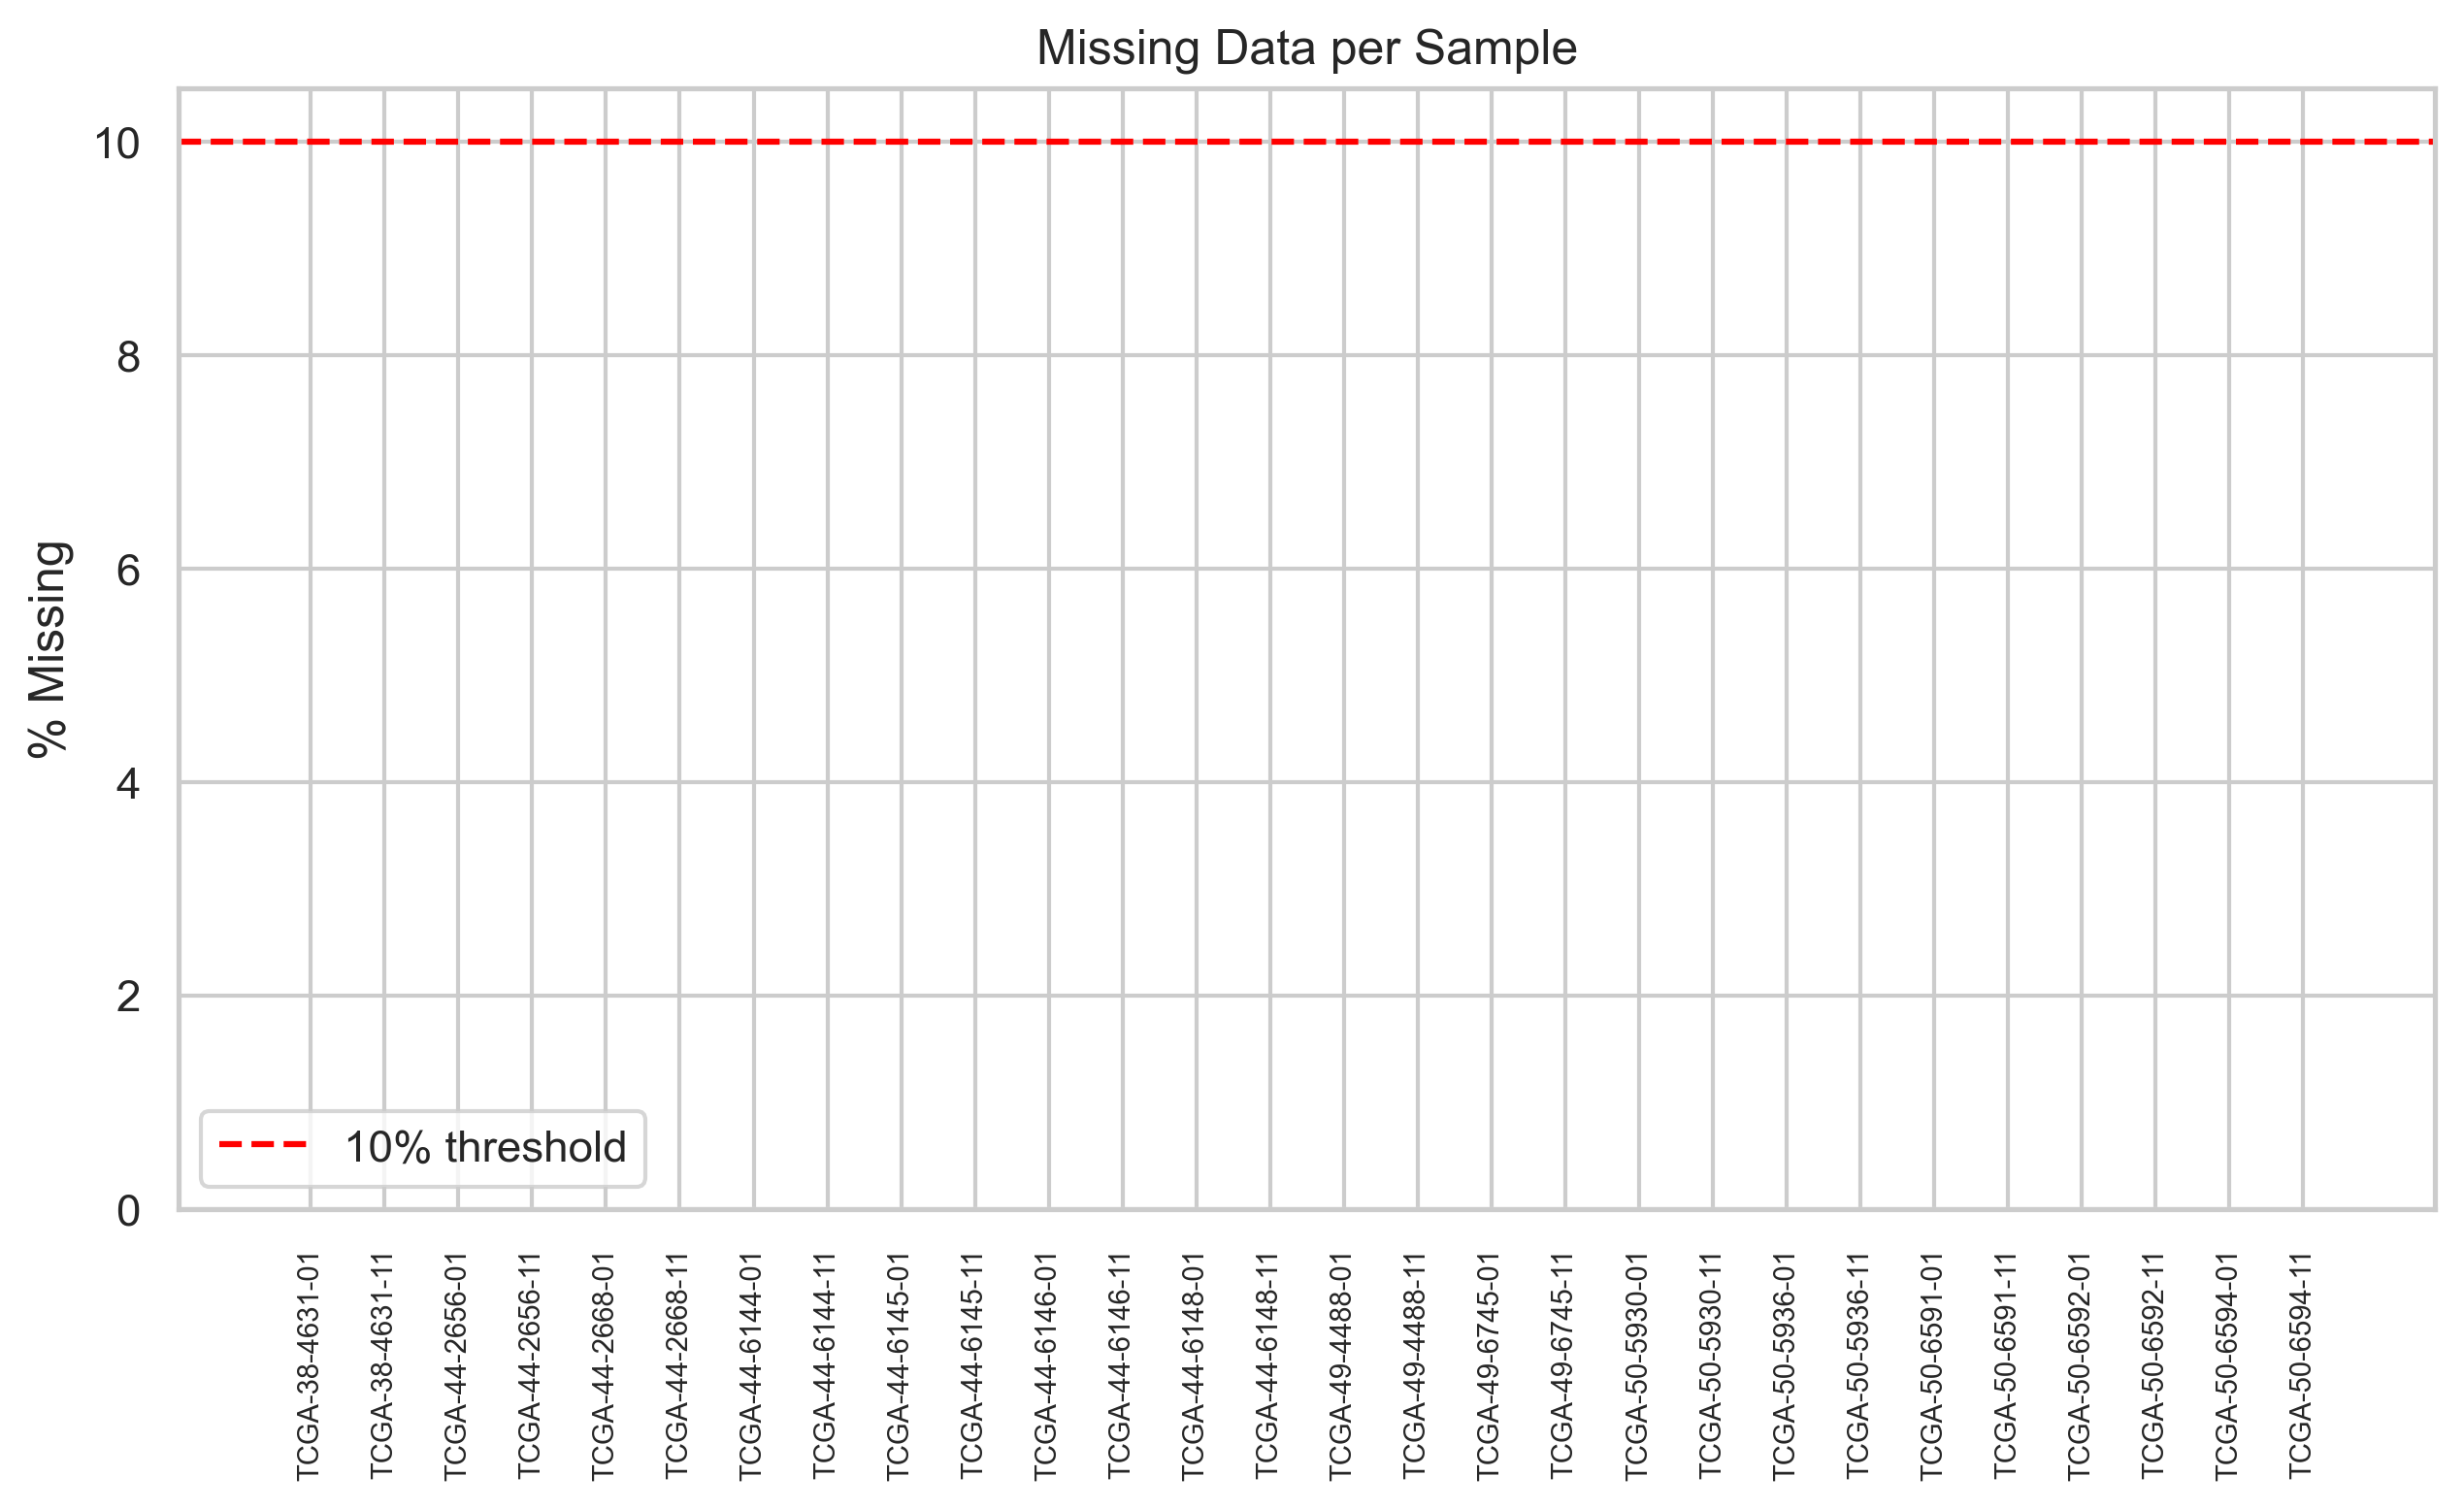

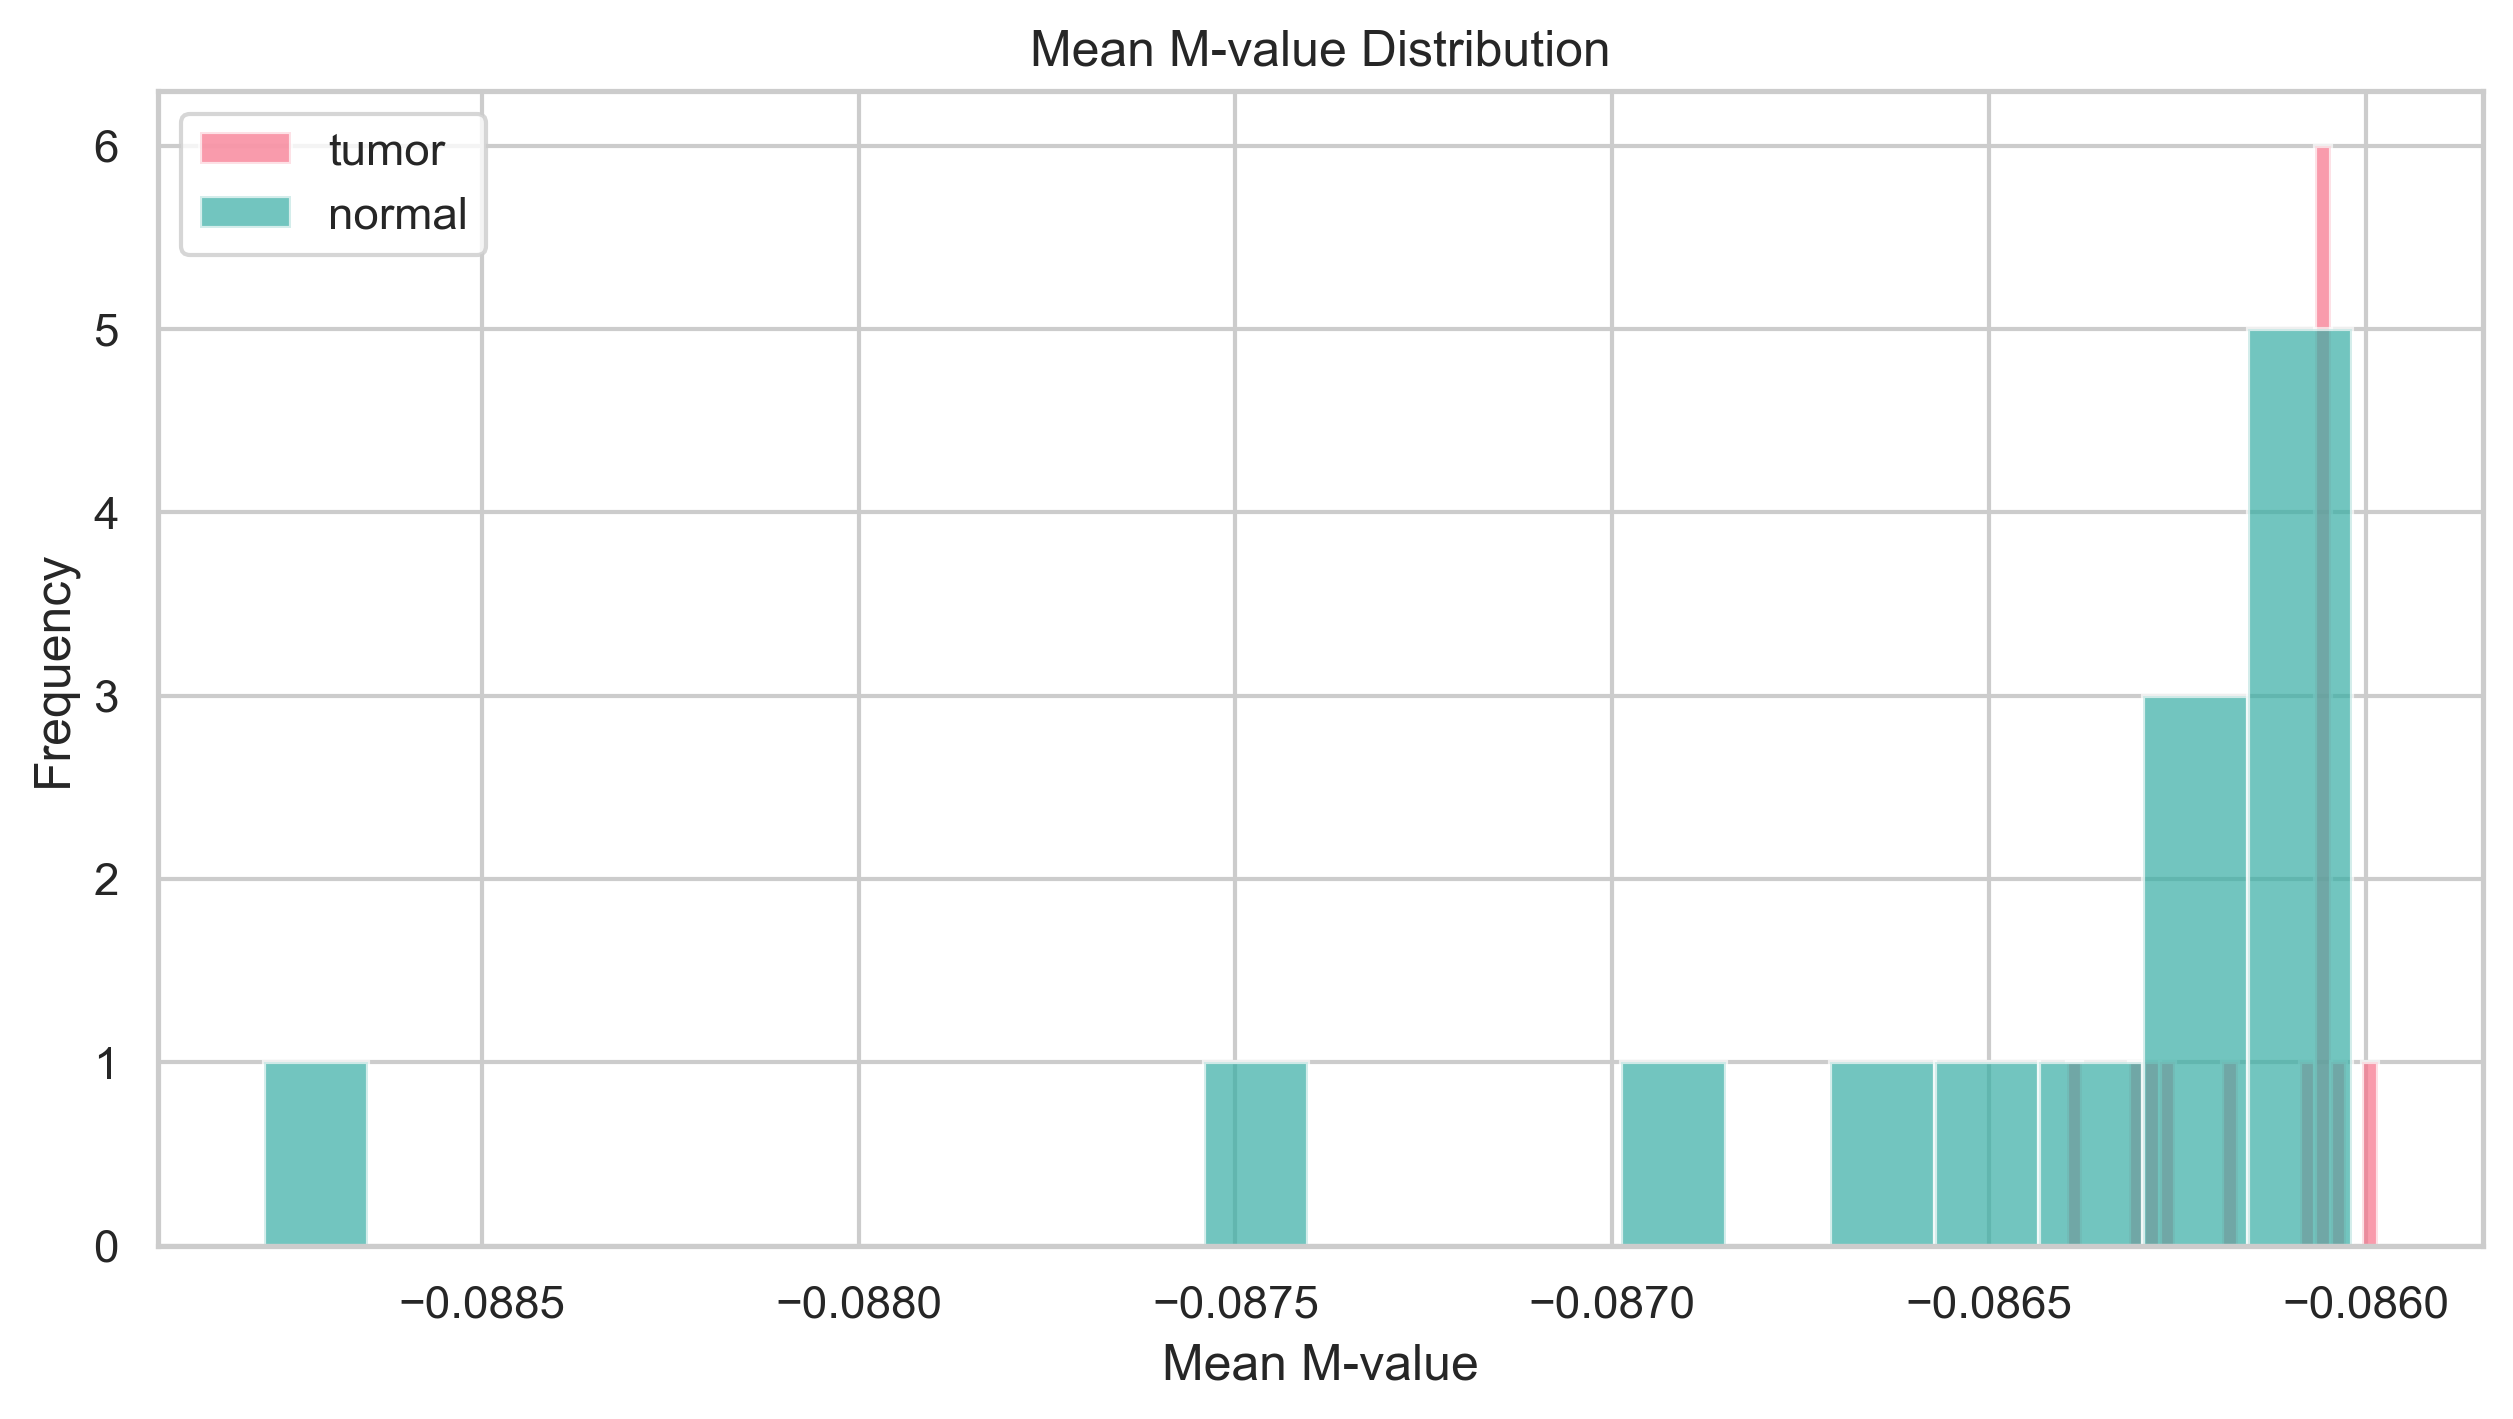

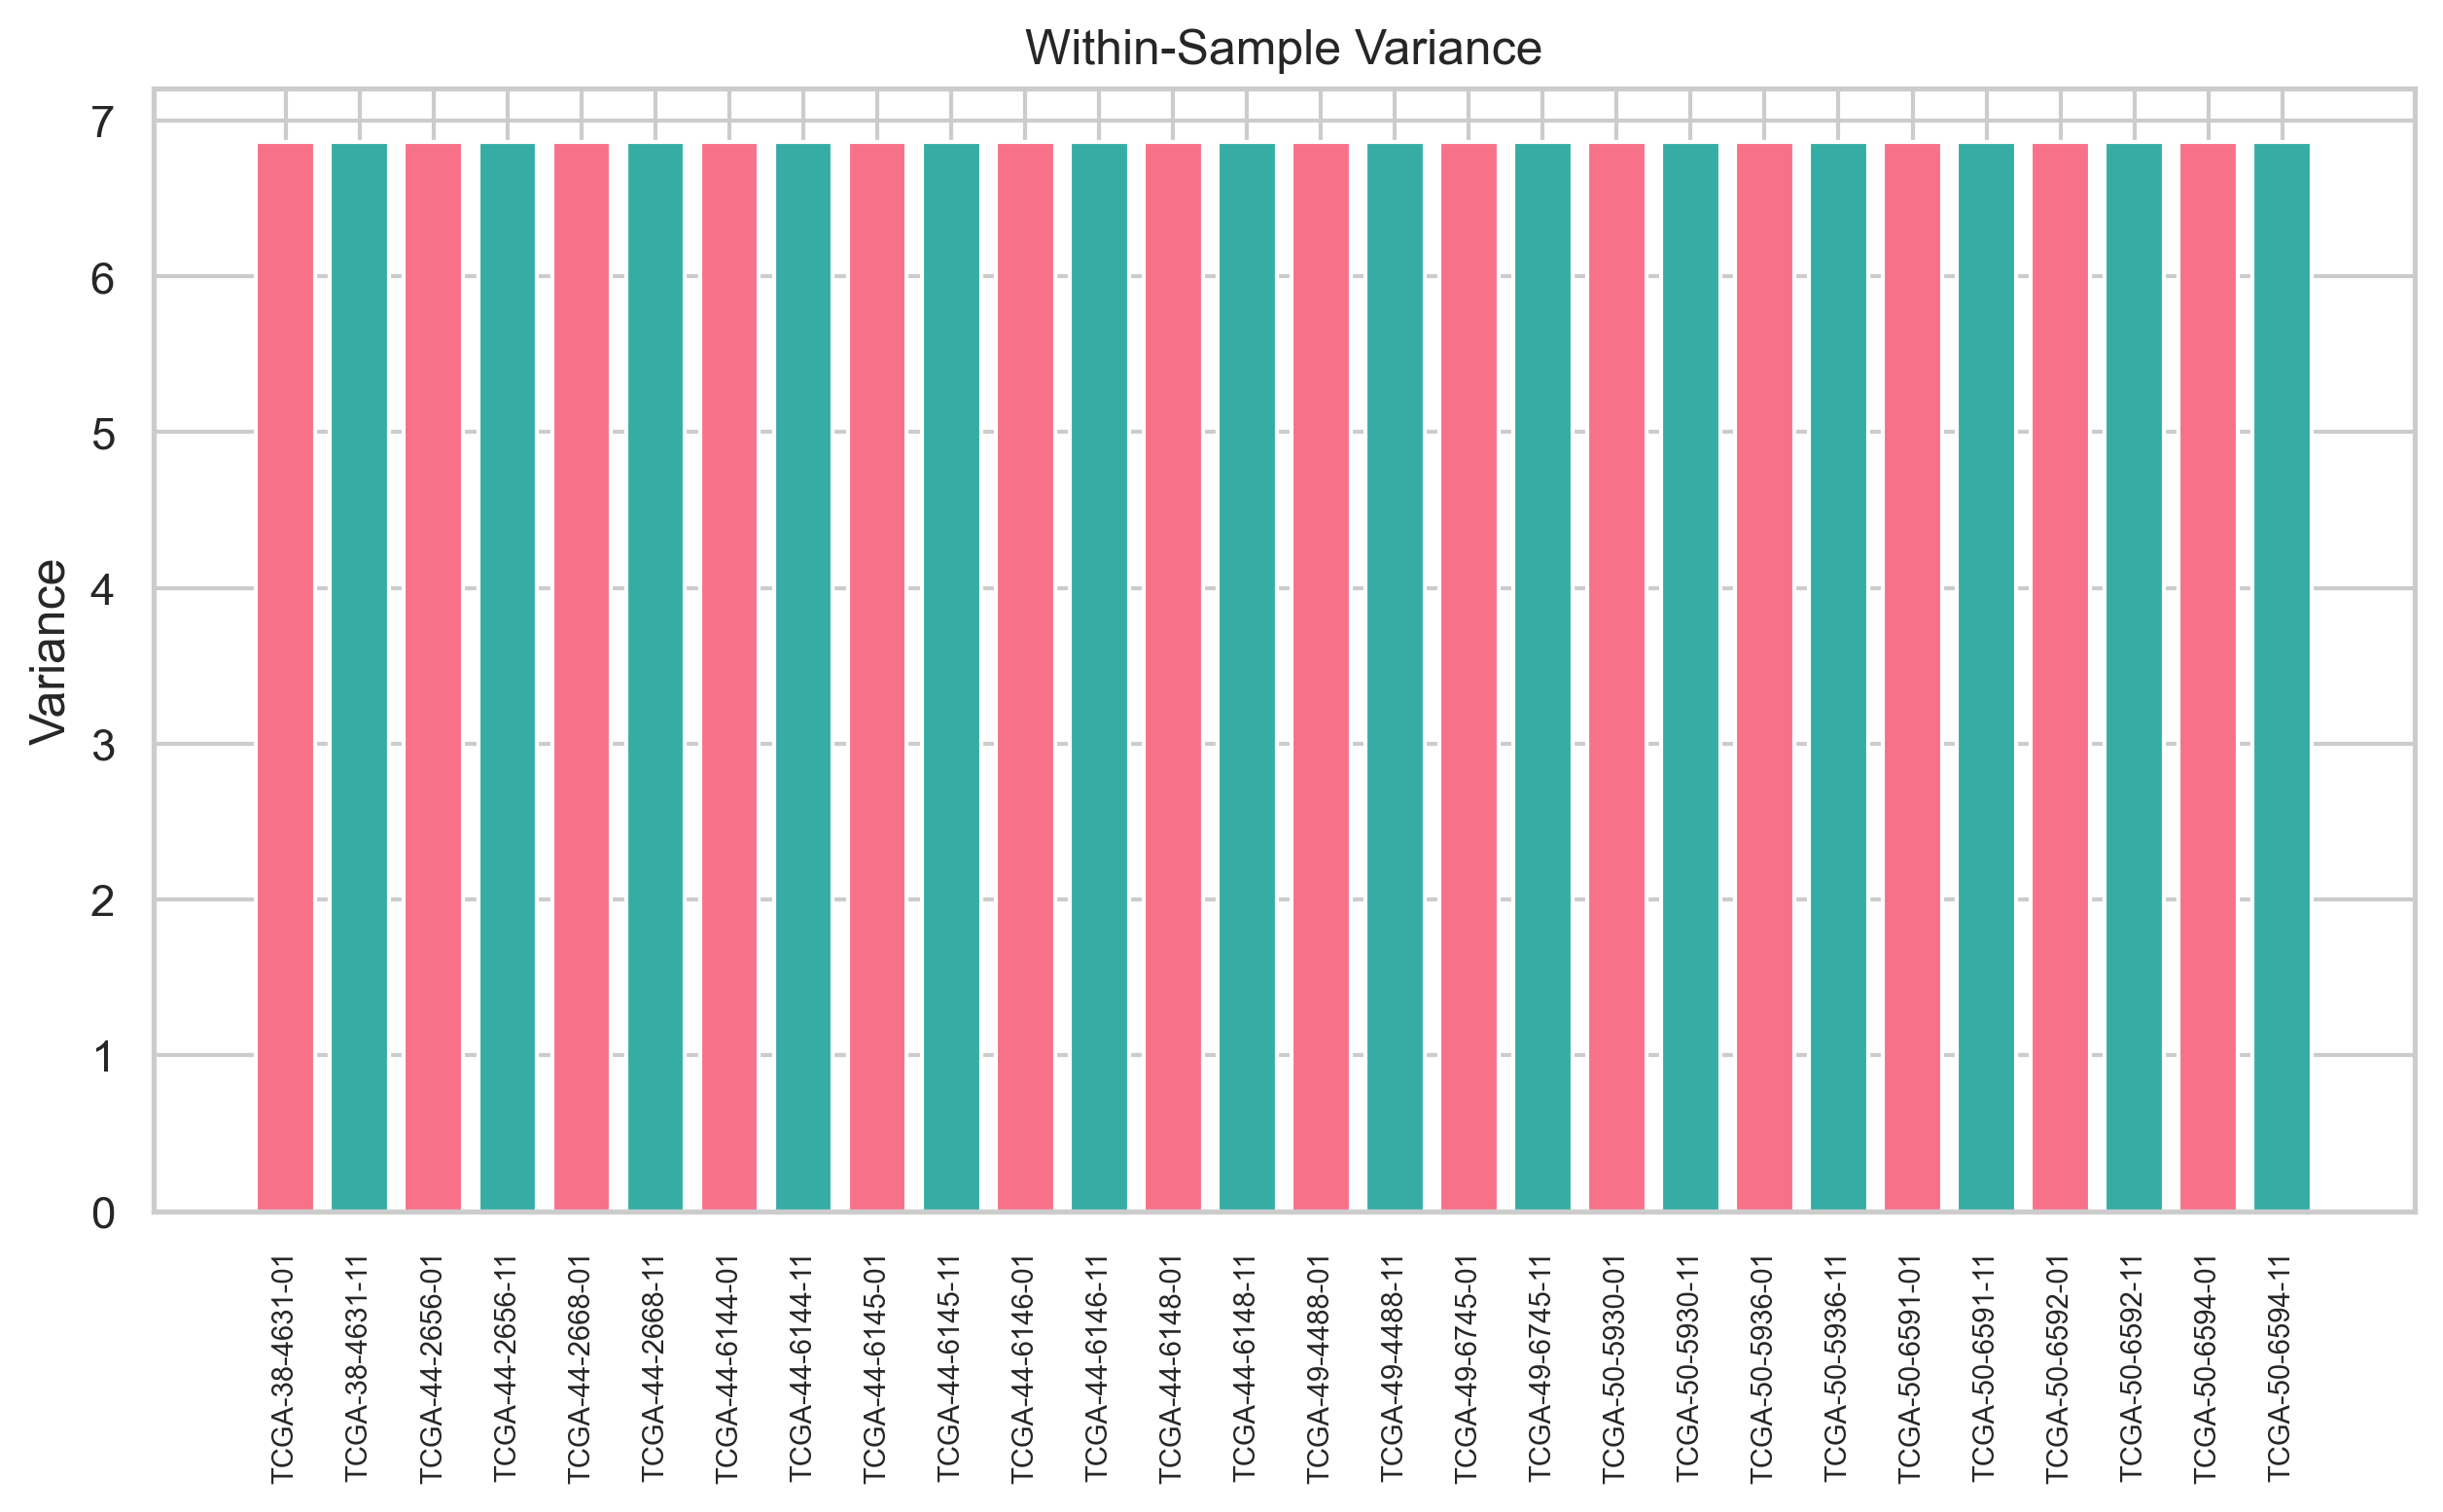

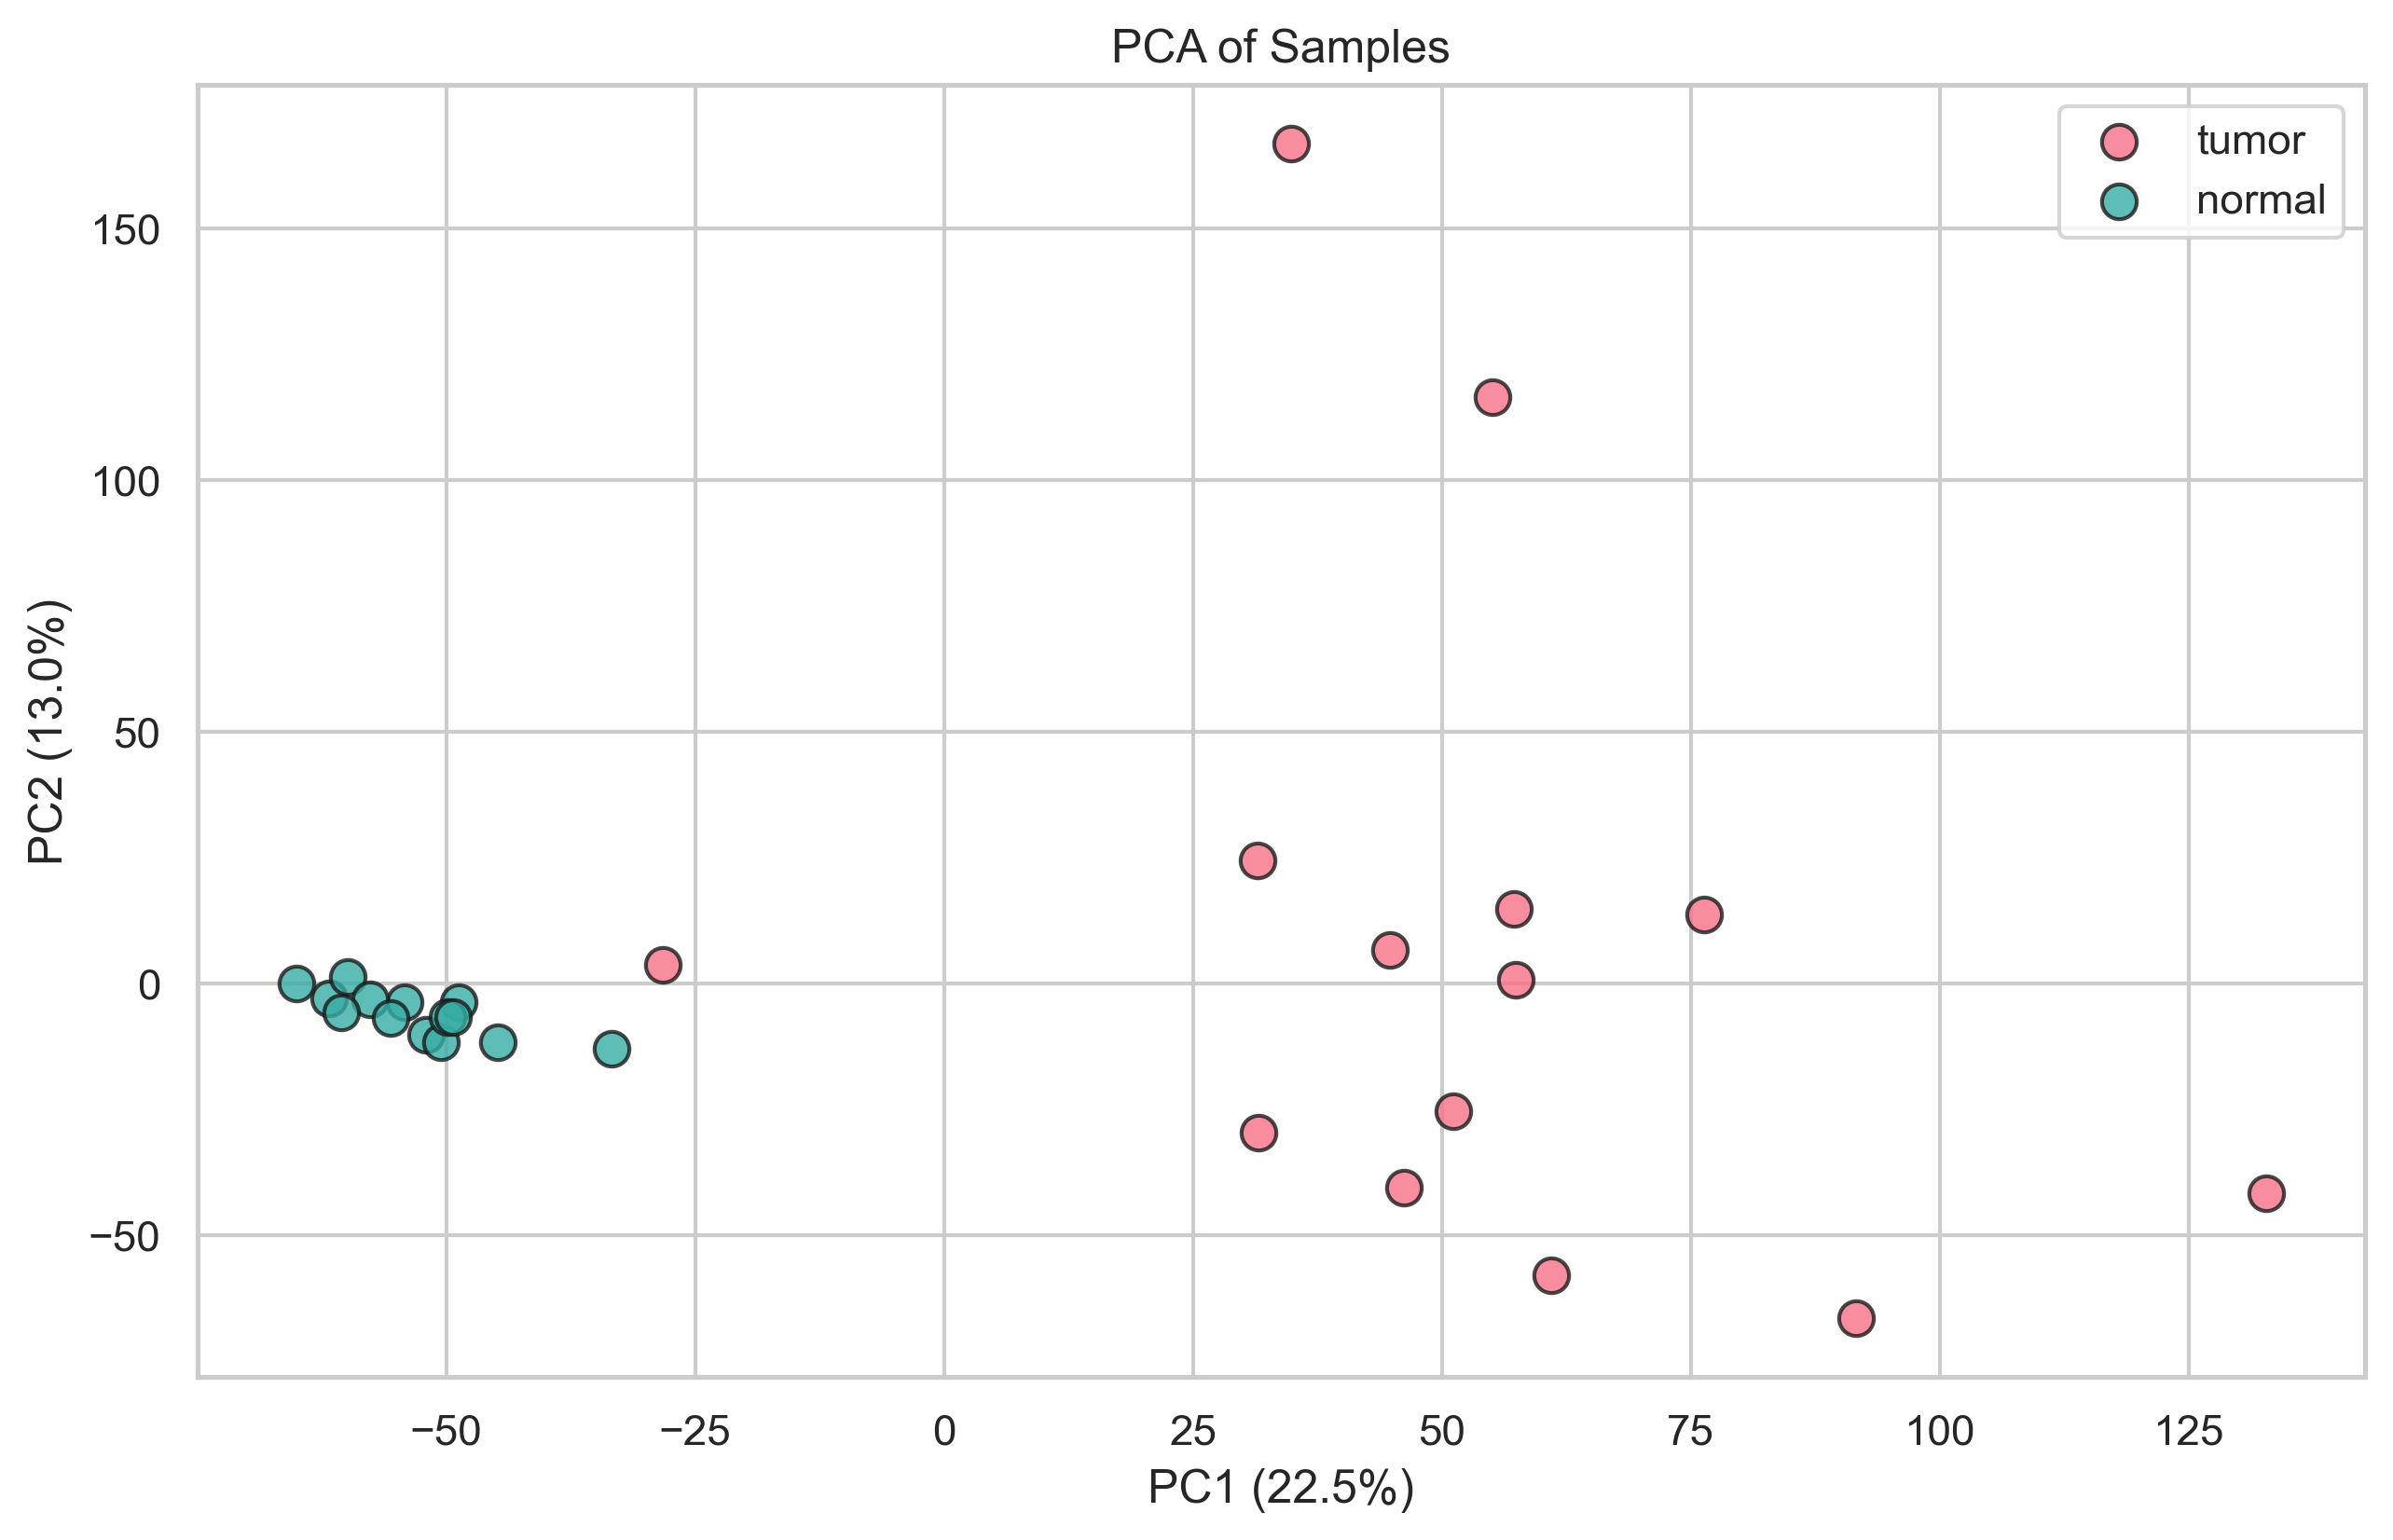

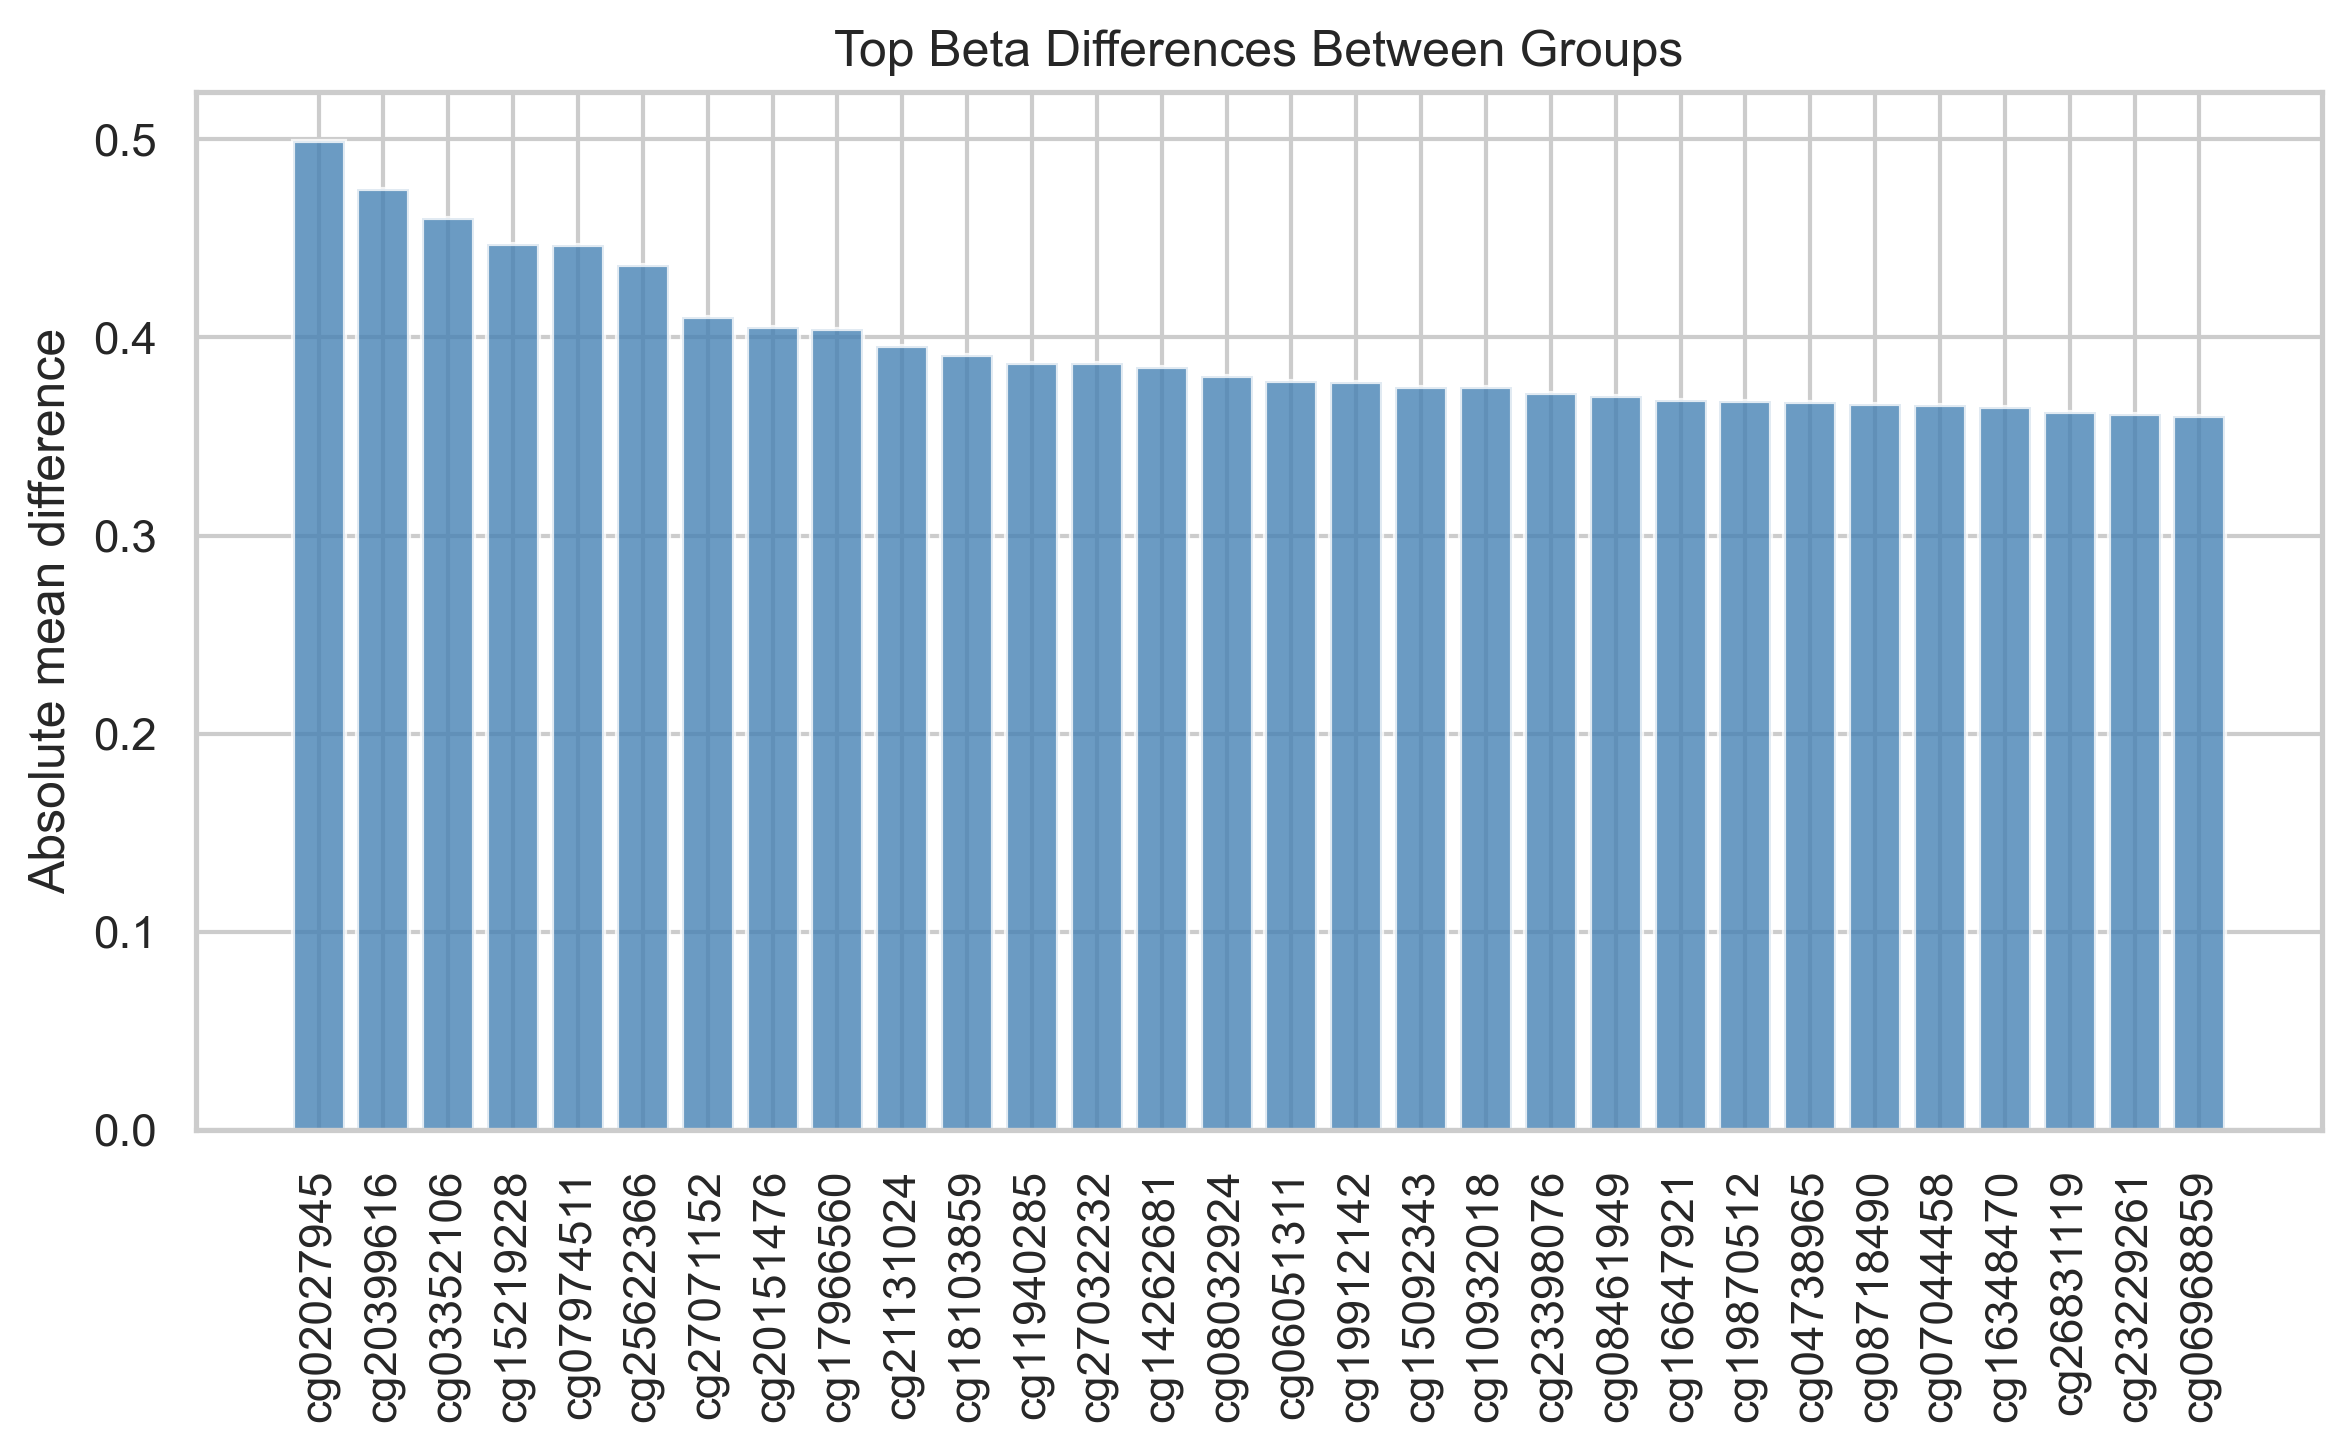

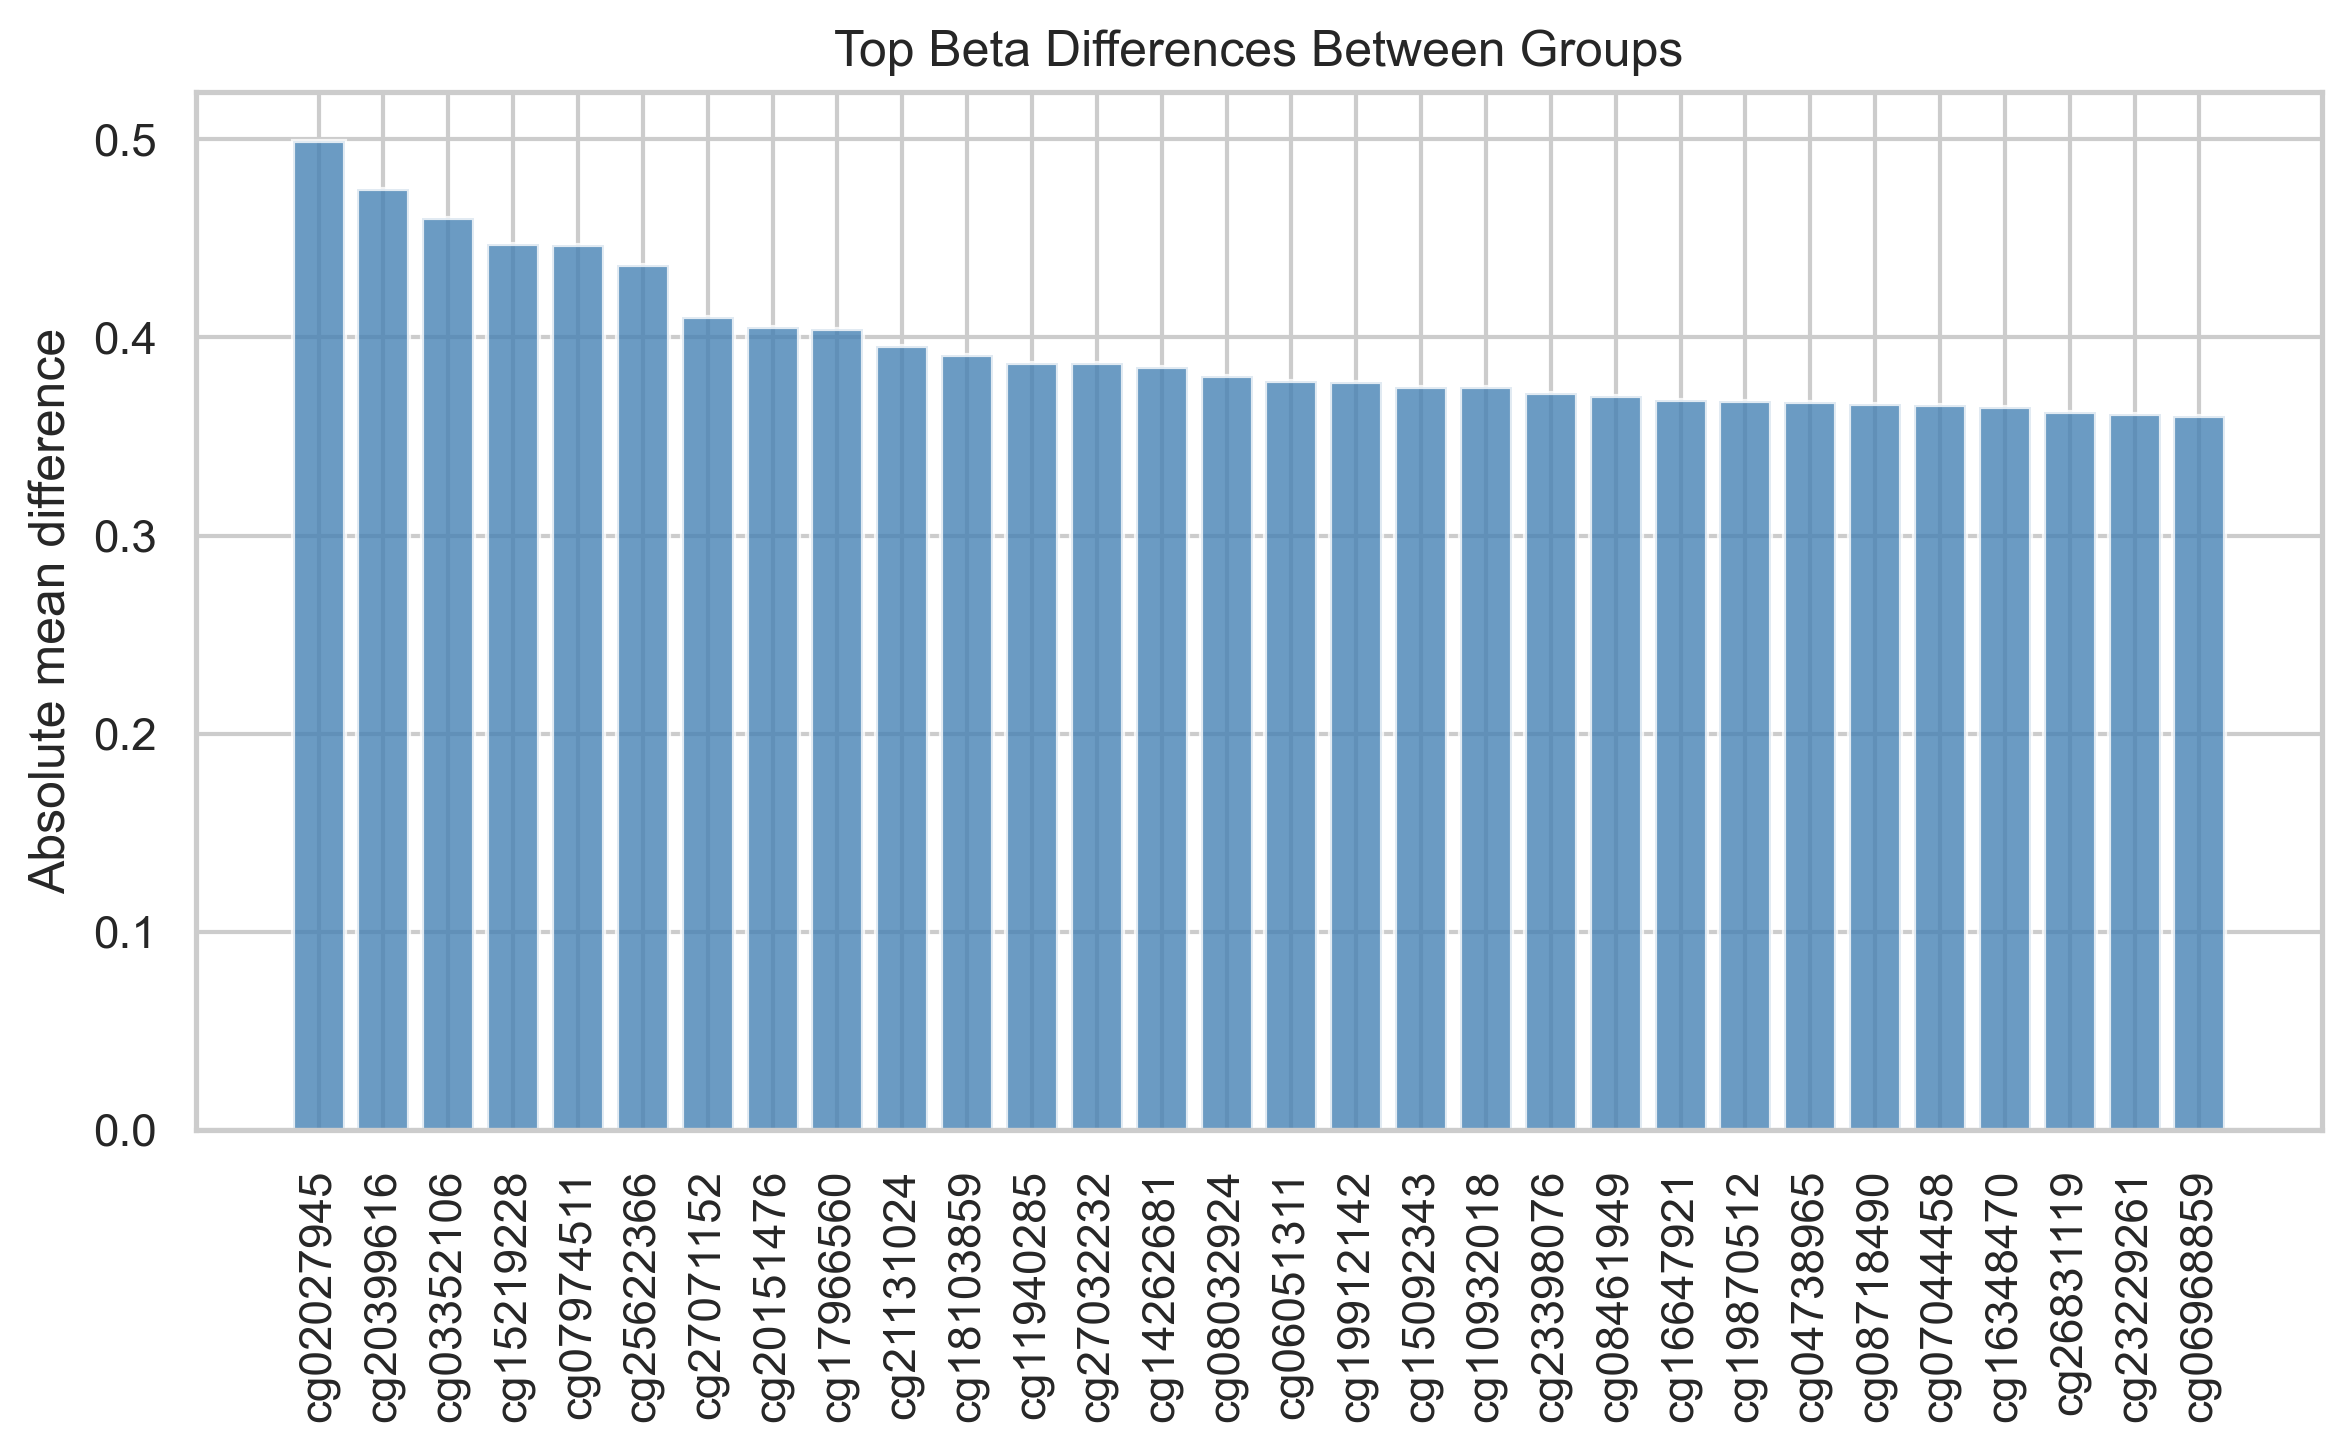

In [23]:
# PCA / embedding QC plots
figs = plot_stage(
    stage="qc",
    M=data.M,
    metadata=data.pheno,
    groups_col="group",
    embedding="pca",
    interactive=False,
)

# Display all figures
plt.close("all")  # clear previous figures
for name, fig in figs.items():
    display(fig)

# Plot top 30 CpGs by mean beta difference
plot_mean_difference(
    betas[data.pheno[data.pheno["group"] == "tumor"].index],
    betas[data.pheno[data.pheno["group"] == "normal"].index],
    top_n=30,
)

#### 4.8 Save Processed Dataset

After preprocessing, QC, normalization, and imputation, it is good practice to save the processed `MethylationData` container using `save_processed_data()`.  

- **Format**: Pickle (`.pkl`) for fast saving and reloading  
- **Trusted reload**: When reloading, set `trusted=True` using `load_processed_data()` to allow full deserialization

In [24]:
save_processed_data(data, "luad_processed.pkl", format="pickle")

[2025-12-01 16:57:55] [INFO] dmeth: Saved ProcessedData in pickle format


In [48]:
data = load_processed_data(path="luad_processed.pkl", trusted=True)
print(
    f"✓ Processed dataset reloaded: {data.M.shape[0]:,} CpGs × {data.M.shape[1]} samples"
)

✓ Processed dataset reloaded: 35,681 CpGs × 28 samples


## 5. Validation

#### 5.1 Create Design Matrix

To validate differential methylation, we first construct a **design matrix** representing the experimental structure using `build_design()`:  

- **Inputs**:  
  - `patient_id`: accounts for paired samples  
  - `group`: tumor vs normal indicator  
- **Options**:  
  - `categorical`: specify which variables are categorical  
  - `add_intercept=True`: includes the intercept term for regression  
  - `drop_first=True`: avoids multicollinearity by dropping the first level of categorical variables

In [49]:
design = build_design(
    data.pheno[["patient_id", "group"]],
    categorical=["patient_id", "group"],
    add_intercept=True,
    drop_first=True,
)

#### 5.2 Create and Validate Contrast

To test differential methylation between tumor and normal samples, we define a **contrast vector** corresponding to the `group` variable in the design matrix.  

- The contrast vector selects the coefficient(s) of interest for hypothesis testing.  
- `validate_contrast()` ensures the vector matches the design matrix structure and is suitable for regression.

In [50]:
contrast = [0] * (design.shape[1] - 1) + [1]
cvec = validate_contrast(design, contrast)

#### 5.3 Ensure Data–Design Alignment

Before fitting the differential methylation model, it is critical to confirm that the **methylation matrix** (`M`) aligns with the **design matrix**. `validate_alignment()`:

- Checks that samples in `M` match the rows of the design matrix  
- Handles paired samples by specifying `paired_ids`  
- Confirms the group column index (`group_col_idx`) corresponds to the factor of interest

This step prevents misalignment errors that could invalidate statistical tests.

In [51]:
_, validated_design, _ = validate_alignment(
    data.M,
    design,
    paired_ids=design.index.str.split("-").str[:3].str.join("-"),
    group_col_idx=14,
)

## 6. Differential analysis

#### 6.1 Check Memory Requirement

Before fitting the differential methylation model across all CpGs, it is important to estimate the **memory usage** required for the analysis. `check_analysis_memory()`:

- Ensures that the dataset can be processed efficiently on the available hardware  
- Helps decide whether to split the analysis into smaller chunks to prevent memory overflow

In [52]:
check_mem = check_analysis_memory(data.M)

print("Estimated memory requirement:\n")
for item, value in check_mem.items():
    print(f"{item}: {value:,}")

Estimated memory requirement:

data_gb: nan
peak_gb: nan
available_gb: nan


#### 6.2 Chunked Moderated Differential Analysis

To identify differentially methylated CpGs (DMCs) between tumor and normal samples, we fit a **linear model with moderated statistics** using `fit_differential_chunked()` with:

- **Chunked processing**: splits the CpG matrix into manageable batches (`chunk_size=25,000`) to handle memory efficiently  
- **Shrinkage**: `"smyth"` applies empirical Bayes moderation to variance estimates, improving reliability for small sample sizes  
- **Robust**: `True` applies robust fitting to reduce the influence of outliers

In [53]:
group_labels = pd.Series(
    np.where(validated_design["group_tumor"], "tumor", "normal"),
    index=data.M.columns,
    name="group",
)

res = fit_differential_chunked(
    M=data.M,
    design=validated_design,
    chunk_size=2.5e4,
    group_labels=group_labels,
    contrast=cvec,
    shrink="smyth",
    robust=True,
)

[2025-12-01 08:17:24] [INFO] dmeth: Processing 35,681 features in 2 chunks...


Numba unavailable, using slower Python loop...: |                          | 0/0

[2025-12-01 08:17:31] [INFO] dmeth: Fitting complete, applying shrinkage...
[2025-12-01 08:17:31] [INFO] dmeth:   1/2 | 7.4s



Numba unavailable, using slower Python loop...: |                          | 0/0

[2025-12-01 08:17:34] [INFO] dmeth: Fitting complete, applying shrinkage...
[2025-12-01 08:17:34] [INFO] dmeth:   2/2 | 10.5s
[2025-12-01 08:17:34] [INFO] dmeth: Finished in 10.5s


#### 6.3 Add Mean Beta Columns for Δβ Constraints

To support downstream filtering based on absolute methylation differences (Δβ), 
we convert the imputed M-values back to β-values using:

\[
\beta = \frac{1}{1 + 2^{-M}}
\]

We then compute group-wise mean β-values (e.g., tumor vs normal) and append them 
as additional columns to the differential results table.

In [54]:
beta_mat = 1 / (1 + 2 ** (-data.M))
group_means = (
    beta_mat.groupby(data.pheno["group"], axis=1)
    .mean()
    .rename(columns=lambda g: f"meanB_{g}")
)

# Align and append
for col in group_means.columns:
    res[col] = group_means[col].reindex(res.index)

#### 6.4 Visualize Differential Methylation

To get a quick overview of differential methylation results, evaluate the distribution of p-values, and check for potential inflation or deflation:

1. **Volcano plot** (`plot_volcano`)
- Provides a quick overview of the differential methylation results:
  - **X-axis**: log fold-change (LogFC) between tumor and normal β-values  
  - **Y-axis**: –Log10(p-value) from the differential test  
- Points in the top-right and top-left quadrants correspond to CpGs that are both statistically significant and biologically meaningful (large methylation differences).  
- Useful for identifying candidate DMCs for downstream analysis.

2. **Q–Q plot** (`plot_pvalue_qq`)  
   - Compares observed p-values against the expected uniform distribution  
   - Deviations from the diagonal indicate systematic effects or model misspecification  

3. **Histogram of p-values** (`pvalue_histogram`)  
   - Visualizes the overall distribution  
   - Helps identify enrichment of low p-values corresponding to true differential methylation signals
  
4. **Mean-variance trend** and **Variance shrinkage** plots (`plot_stage`)
   - Displays the relationship between mean methylation levels and variance
   - Highlights heteroscedasticity and the effectiveness of variance moderation/shrinkage
   - Ensures the assumptions of linear modeling are reasonably met


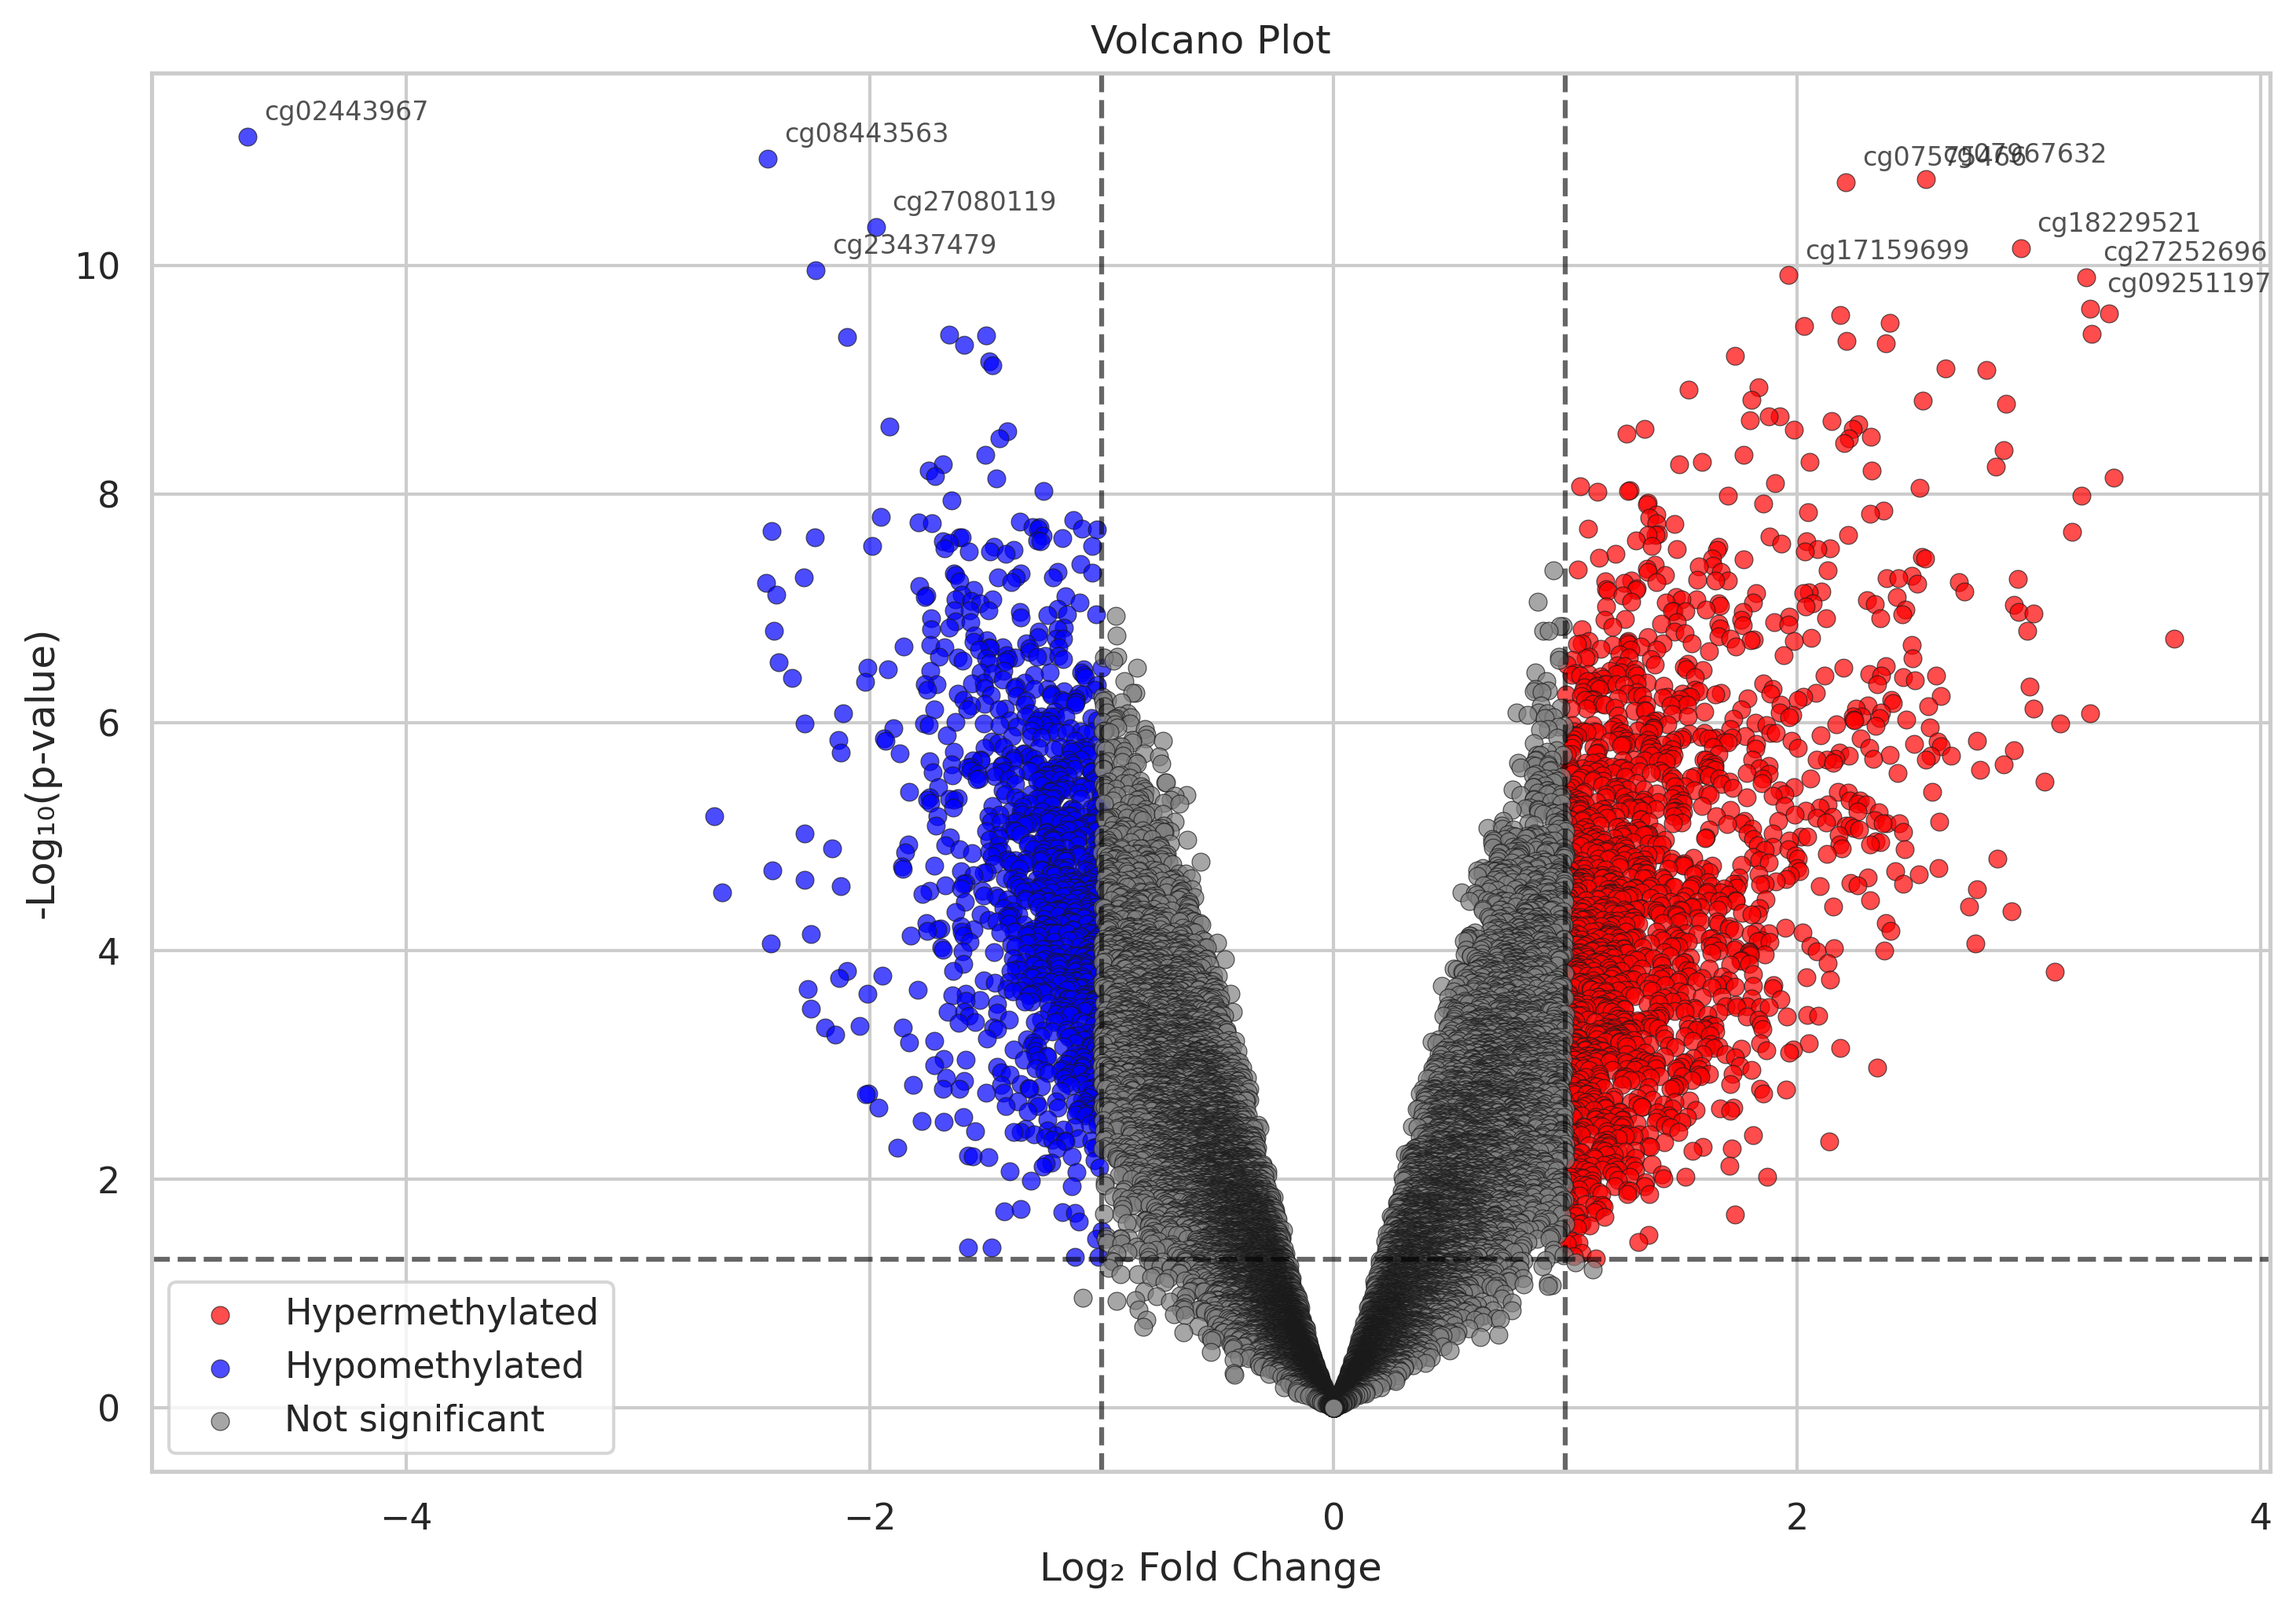

In [55]:
plt.rcParams["font.family"] = "DejaVu Sans"  # Run if plot gives font warnings
plot_volcano(res, lfc_col="logFC", pval_col="pval")

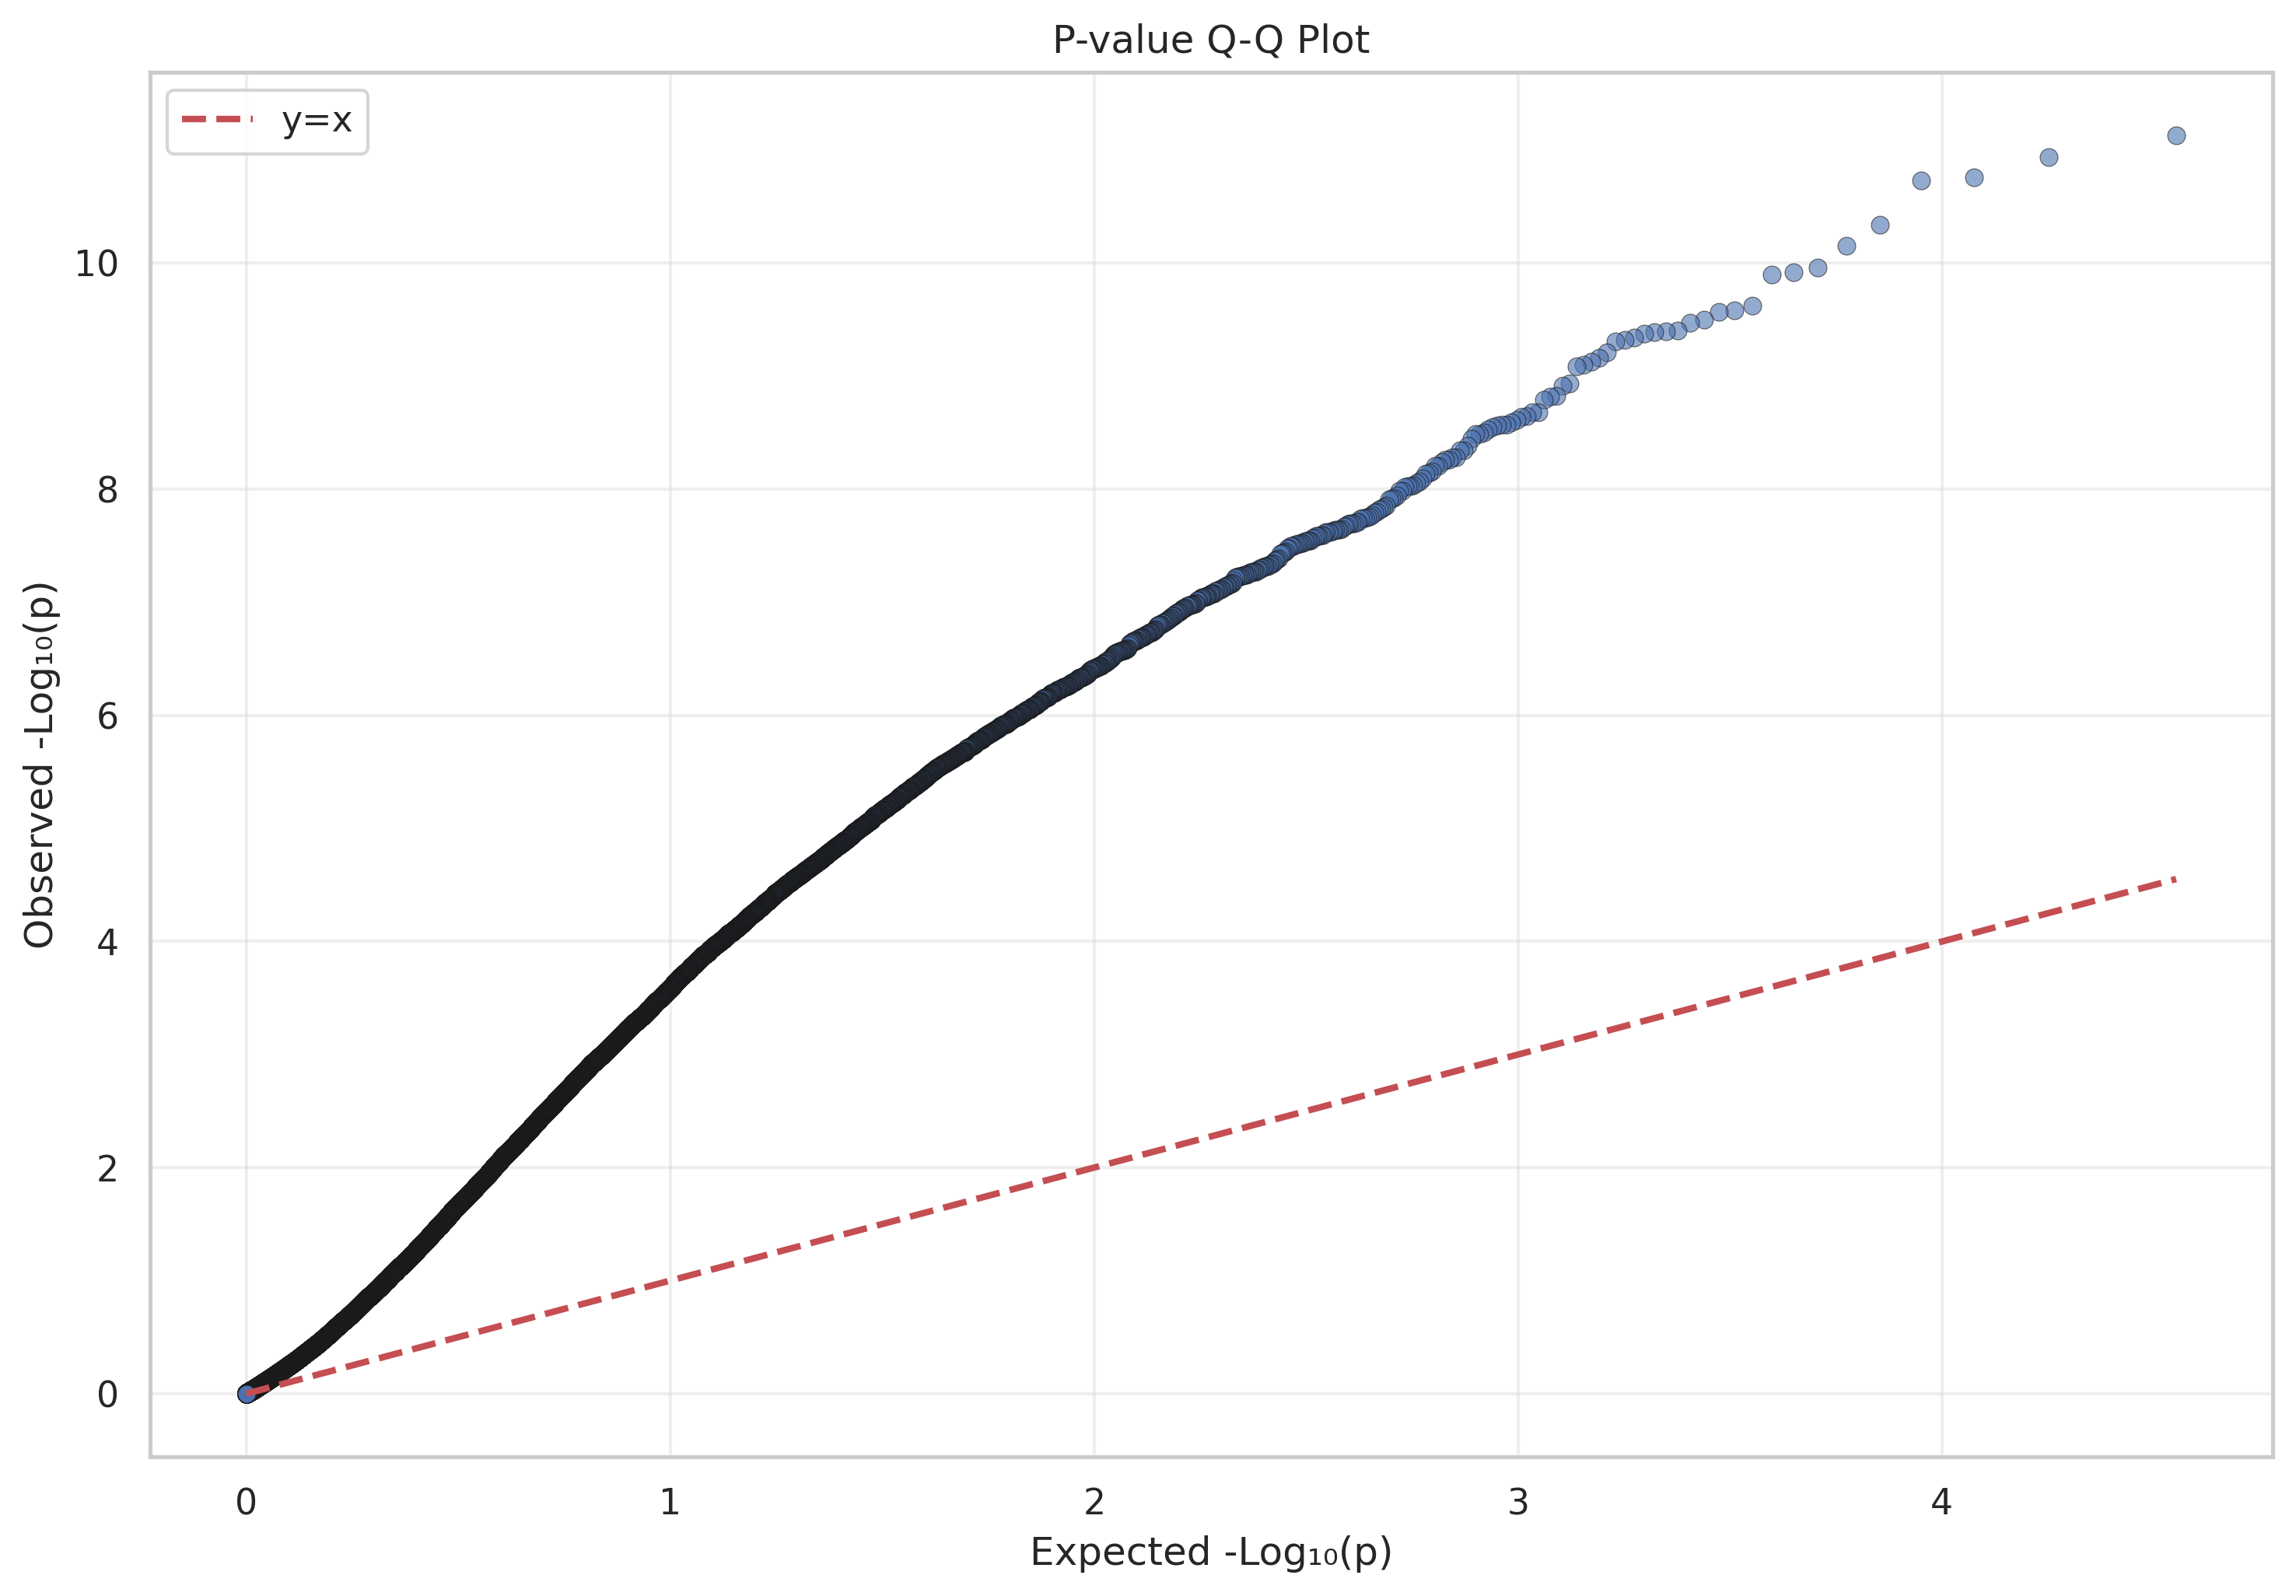

In [56]:
plot_pvalue_qq(res, pval_col="pval")

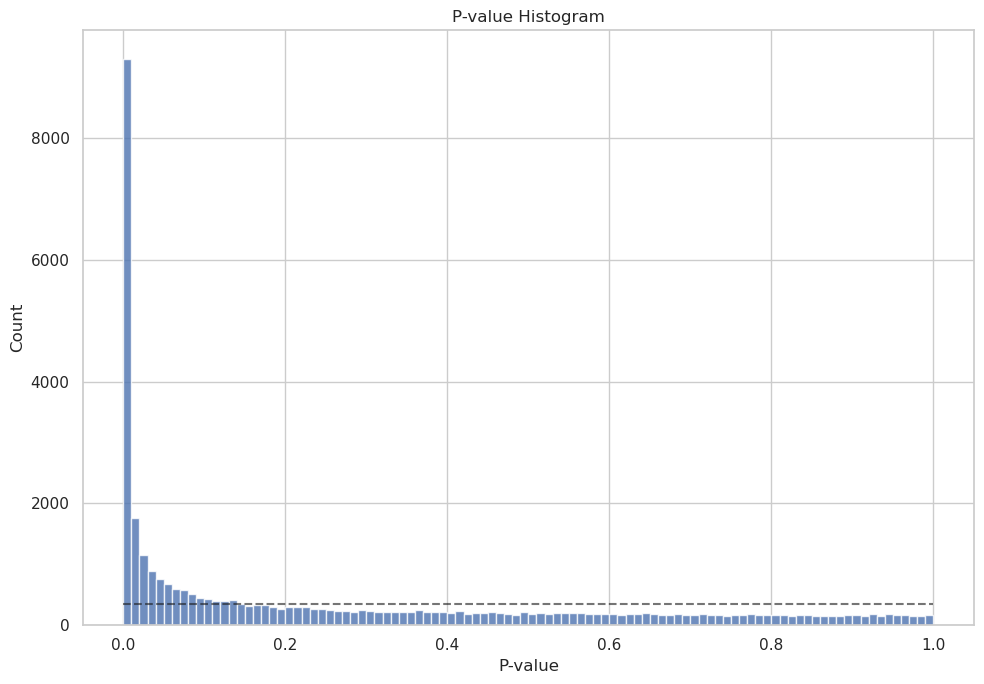

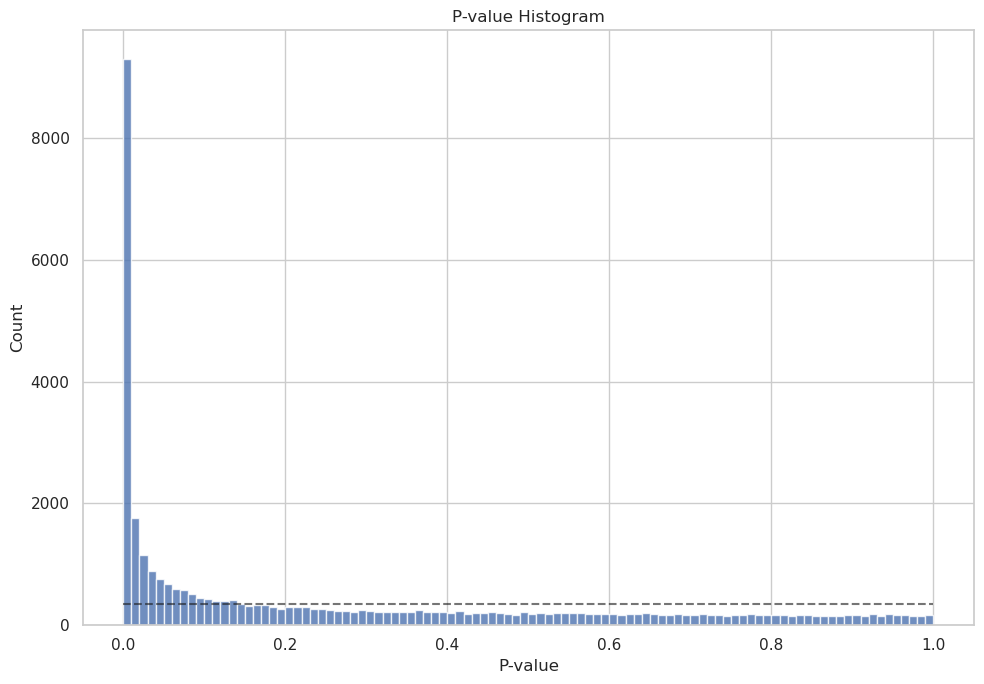

In [57]:
pvalue_histogram(res["pval"], bins=100)

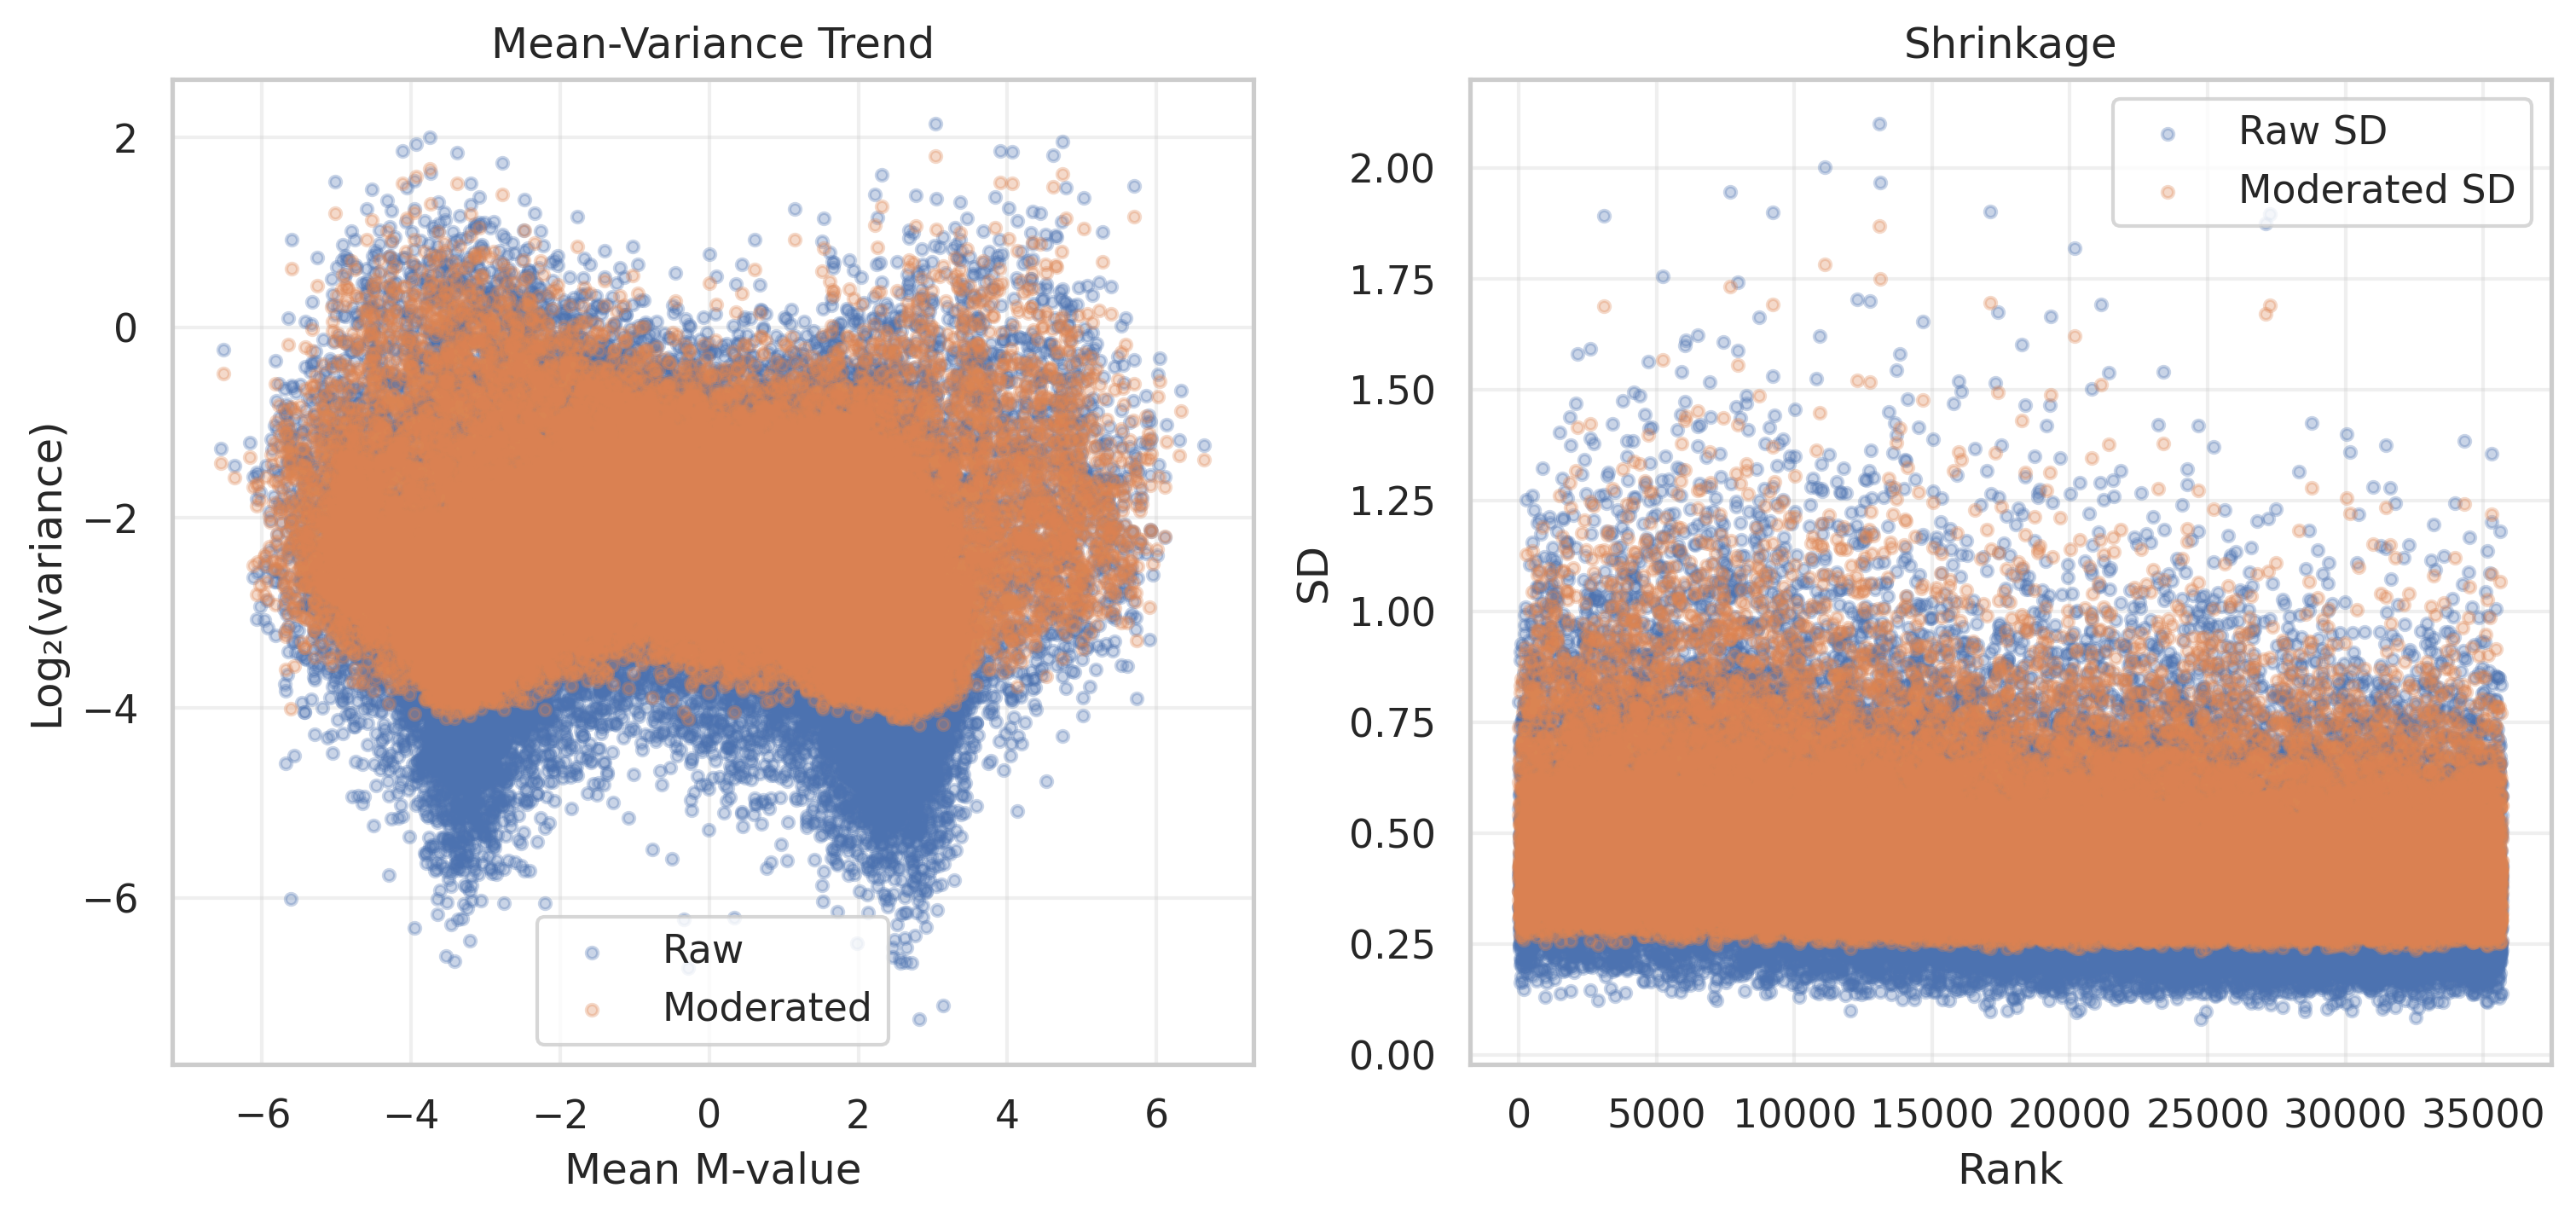

In [58]:
figs = plot_stage(M=data.M, res=res, stage="variance")
plt.close("all")  # optional: clears any previous figures
for name, fig in figs.items():
    display(fig)

## 7. Post-processing

#### 7.1 Compute Δβ (Delta Beta)

Δβ represents the absolute difference in mean β-values between tumor and normal groups:

\[
\Delta\beta = \text{mean}(\beta_\text{tumor}) - \text{mean}(\beta_\text{normal})
\]

It provides a biologically interpretable measure of methylation change at each CpG.

In [59]:
res["delta_beta"] = compute_delta_beta(
    mean_beta_group1=res["meanB_tumor"], mean_beta_group2=res["meanB_normal"]
)

#### 7.2 Extract Significant CpGs (Multi-Criterion Filter)

Significant CpGs are identified using `get_significant_cpgs()` with multiple criteria:

- **|logFC| ≥ 1.0**: substantial effect size  
- **p-value ≤ 0.05**: statistically significant  
- **Δβ ≥ 0.20**: biologically meaningful methylation difference  

*CpGs can be optionally filtered by **direction** (hyper- or hypo-methylated).*

In [60]:
sig_summary = get_significant_cpgs(
    res,
    lfc_thresh=1.0,
    pval_thresh=0.05,
    delta_beta_thresh=0.20,
    direction=None,
    return_summary=True,
)

print("Significant summary:\n")
{print(f"{k}: {v}\n") for k, v in sig_summary.items() if k != "cpg_list"}

Significant summary:

n_significant: 818

n_hyper: 533

n_hypo: 285

mean_abs_lfc: 1.7154591668487476

cpgs: ['cg02443967', 'cg08443563', 'cg07967632', 'cg27080119', 'cg18229521', 'cg23437479', 'cg17159699', 'cg27252696', 'cg09251197', 'cg16887264', 'cg19211880', 'cg08293531', 'cg00682263', 'cg19912142', 'cg16905506', 'cg26188212', 'cg06215569', 'cg01871581', 'cg02637537', 'cg08849558', 'cg03532926', 'cg19084726', 'cg22270027', 'cg09317554', 'cg15962969', 'cg06183338', 'cg25691167', 'cg26980034', 'cg27032146', 'cg03405909', 'cg23413697', 'cg02093732', 'cg08857994', 'cg24035682', 'cg11014794', 'cg08032924', 'cg02037307', 'cg05311410', 'cg14823851', 'cg22534145', 'cg03441770', 'cg26213458', 'cg27360326', 'cg14425564', 'cg04923174', 'cg05809668', 'cg19205041', 'cg13944175', 'cg00339556', 'cg26485937', 'cg10450692', 'cg20779964', 'cg24444059', 'cg19760241', 'cg14750948', 'cg24430140', 'cg07318983', 'cg26221111', 'cg19641327', 'cg11171825', 'cg11302791', 'cg07044458', 'cg00249511', 'cg16675

{None}

#### 7.3 General Summary of Differential Results

After fitting the differential methylation model, we can summarize key statistics across all tested CpGs using `summarize_differential_results()`:

- **total_tested**: total number of CpGs analyzed  
- **significant**: number of CpGs meeting the significance criteria (p-value ≤ 0.05, |logFC| ≥ 1.0)  
- **pct_significant**: proportion of tested CpGs that are significant  
- **hypermethylated / hypomethylated**: counts of CpGs with positive vs negative logFC  
- **mean_abs_logFC_sig / median_abs_logFC_sig**: magnitude of methylation changes among significant CpGs  
- **max_abs_logFC / min_pval**: extremes for effect size and statistical significance  
- **shrinkage_factor / d0**: parameters from moderated variance estimation

In [61]:
res_summary = summarize_differential_results(res, pval_thresh=0.05, lfc_thresh=1.0)
print("Results summary:\n")
{print(f"{k}: {v}\n") for k, v in res_summary.items()}

Results summary:

total_tested: 35681

significant: 2796

pct_significant: 7.8361032482273485

hypermethylated: 1706

hypomethylated: 1090

mean_abs_logFC_sig: 1.384575306747166

median_abs_logFC_sig: 1.2577182030451883

max_abs_logFC: 4.6850568432086295

min_pval: 7.376454770991076e-12

shrinkage_factor: 1.0759893410102823

d0: 3.679024511934093



{None}

## 8. Dowmstream Analysis
#### 8.1 Differentially Methylated Region (DMR) Discovery

Differentially methylated regions (DMRs) are clusters of CpGs showing consistent methylation changes. Here, we identify DMRs using `find_dmrs_by_sliding_window()` by sliding a window across the genome over **significant DMS** obtained from `filter_dms()`:

- **max_gap:** 500 bp between consecutive CpGs  
- **min_cpgs:** at least 3 CpGs per DMR  
- **Filters:** adjusted p-value ≤ 0.05, |logFC| ≥ 1, Δβ ≥ 0.2  

The resulting DMR table includes:

- Chromosome (`chr`), start and end coordinates  
- Number of CpGs in the region (`n_cpgs`)  
- Mean Δβ and mean logFC across the region  
- Minimum adjusted p-value (`min_padj`)  
- List of CpGs in the DMR

In [62]:
sig_dms = filter_dms(
    res,
    lfc_col="logFC",
    pval_col="padj",
    pval_thresh=0.05,
    lfc_thresh=1.0,
    delta_beta_thresh=0.2,
)

dmrs = find_dmrs_by_sliding_window(
    dms=sig_dms,
    annotation=data.ann,
    chr_col="CHR",
    pos_col="MAPINFO",
    max_gap=250,
    min_cpgs=3,
)

print(f"Found {len(dmrs)} DMRs:")

dmrs

Found 10 DMRs:


chr      start        end  n_cpgs  mean_delta_beta  mean_logFC  min_padj  \
0   chr1   67217769   67218165       5         0.271549    2.161360  0.000019   
1  chr16   66613096   66613278       3         0.297638    1.987362  0.000003   
2  chr17    7758204    7758397       3         0.176964    1.606704  0.000089   
3  chr18   14748220   14748439       3         0.215789    1.396549  0.000333   
4   chr3   50378431   50378611       3         0.170440    1.693158  0.000756   
5   chr5   16180048   16180266       3         0.231357    2.506753  0.000005   
6   chr5   33936307   33936520       3         0.182864    1.724371  0.000123   
7   chr6   29943414   29943455       3         0.197969    1.612938  0.000519   
8   chr7   96654782   96654832       4         0.164176    1.133527  0.003720   
9   chr7  117119393  117119611       3         0.244574    1.702358  0.000524   

                                                cpgs  
0  [cg09769134, cg08857729, cg19808205, cg1728480...  
1               [cg08032924, cg07153665, cg06666025]  
2               [cg21845633, cg02459416, cg18410680]  
3               [cg13266435, cg03014326, cg02992546]  
4               [cg27569446, cg06172942, cg04540383]  
5               [cg00339556, cg18325622, cg23065934]  
6               [cg13349651, cg15408073, cg02640041]  
7               [cg04623837, cg16368146, cg04109898]  
8   [cg01448276, cg16876790, cg10243939, cg17083494]  
9               [cg09181792, cg26635219, cg17616554]

#### 8.2 DMR Summary Statistics

Once DMRs are identified, it can be useful to summarize their overall characteristics. This can be done using `summarize_regions()`:

In [63]:
dmr_summary = summarize_regions(dmrs)

print("DMR summary:\n")
dmr_summary

DMR summary:



n_regions  median_length  mean_n_cpgs  mean_delta_beta  min_padj
0         10            203          3.3         0.215332  0.000003

#### 8.3 Annotatee DMSs with the nearest gene

##### 8.3.1 Load Gene Annotation File

To map CpGs to genes, we first load a reference gene annotation file:

In [64]:
gene_ann = pd.read_csv("genes.tsv", delimiter="\t")
print(f"✓ Gene annotation dataframe shape: {gene_ann.shape}")

✓ Gene annotation dataframe shape: (78899, 7)


##### 8.3.2 Annotate Significant CpGs with Gene Information

We map the significant CpGs (DMSs) to nearby genes using `map_dms_to_genes()` to link methylation changes to potential gene regulation.

In [65]:
sig_dms_ann = pd.merge(
    sig_dms, data.ann[["CHR", "MAPINFO"]], how="left", left_index=True, right_index=True
)

sig_dms_genes = map_dms_to_genes(
    dms=sig_dms_ann,
    genes=gene_ann,
    cpg_chr_col="CHR",
    cpg_pos_col="MAPINFO",
    gene_chr_col="chr",
    gene_start_col="start",
    gene_end_col="end",
    gene_name_col="gene_name",
    max_distance=5000,
)

##### 8.3.3 Sample visualizations of CpG gene annotation

In [66]:
# Define biological order and colors
relation_order = [
    "proximal_promoter",
    "distal_promoter",
    "distal_upstream",
    "gene_body",
    "promoter_downstream",
    "intergenic",
]

color_map = {
    "proximal_promoter": "#d32f2f",
    "distal_promoter": "#f57c00",
    "distal_upstream": "#1976d2",
    "promoter_downstream": "#fbc02d",
    "gene_body": "#388e3c",
    "intergenic": "#757575",
}


def plot_dms_summary(df, relation_order, color_map, title_prefix="Hypermethylated"):
    """
    Produce:
      1) A count barplot by genomic region
      2) A distance violin plot (log scale)
      3) A summary table returned as a DataFrame
    """
    # Summary Table
    table_rows = []
    total = len(df)

    for rel in relation_order:
        sub = df[df["relation"] == rel]

        count = len(sub)
        pct = (count / total * 100) if total > 0 else 0

        dist = sub["distance_bp"].dropna()
        med = int(dist.median()) if len(dist) else 0
        mean = int(dist.mean()) if len(dist) else 0

        table_rows.append(
            [
                rel.replace("_", " ").title(),
                f"{count:,}",
                f"{pct:.1f}%",
                f"{med:,}",
                f"{mean:,}",
            ]
        )

    summary_table = pd.DataFrame(
        table_rows,
        columns=["Region", "Count", "Proportion (%)", "Median (bp)", "Mean (bp)"],
    )

    # Figure Layout
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(7, 10), dpi=200, height_ratios=[1, 1.5])

    # Plot 1: Count Barplot
    ax1 = axes[0]
    counts = df["relation"].value_counts().reindex(relation_order).fillna(0).astype(int)

    ax1.bar(
        x=range(len(relation_order)),
        height=counts.values,
        color=[color_map[r] for r in relation_order],
        edgecolor="black",
        linewidth=1.2,
        alpha=0.75,
    )

    for i, v in enumerate(counts.values):
        ax1.text(
            i, v + max(counts) * 0.02, f"{v:,}", ha="center", va="bottom", fontsize=10
        )

    ax1.set_xticks(range(len(relation_order)))
    ax1.set_xticklabels([r.replace("_", "\n") for r in relation_order], fontsize=10)
    ax1.set_ylabel("Count", fontsize=12, fontweight="bold")
    ax1.set_title(
        f"{title_prefix} DMS Count", fontsize=14, fontweight="bold", loc="left"
    )
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    # Plot 2: Distance Violin
    ax2 = axes[1]

    violin_data = [
        df[df["relation"] == r]["distance_bp"].dropna()
        if (df["relation"] == r).any()
        else pd.Series([1])
        for r in relation_order
    ]

    parts = ax2.violinplot(
        violin_data, positions=range(len(relation_order)), showmedians=True, widths=0.7
    )

    # Color violins
    for body, rel in zip(parts["bodies"], relation_order):
        body.set_facecolor(color_map[rel])
        body.set_edgecolor("black")
        body.set_alpha(0.7)

    parts["cmedians"].set_color("black")
    parts["cmedians"].set_linewidth(2)

    ax2.set_xticks(range(len(relation_order)))
    ax2.set_xticklabels([r.replace("_", "\n") for r in relation_order], fontsize=10)
    ax2.set_yscale("log")
    ax2.set_ylabel("Distance to Gene (bp)", fontsize=12, fontweight="bold")
    ax2.set_xlabel("Genomic Region", fontsize=12, fontweight="bold")
    ax2.set_title(
        f"{title_prefix} Distance Distribution",
        fontsize=14,
        fontweight="bold",
        loc="left",
    )

    ax2.grid(axis="y", alpha=0.3)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.yaxis.set_major_formatter(ScalarFormatter())

    plt.tight_layout()
    plt.show()

    return fig, summary_table

##### A. Hypermethylated

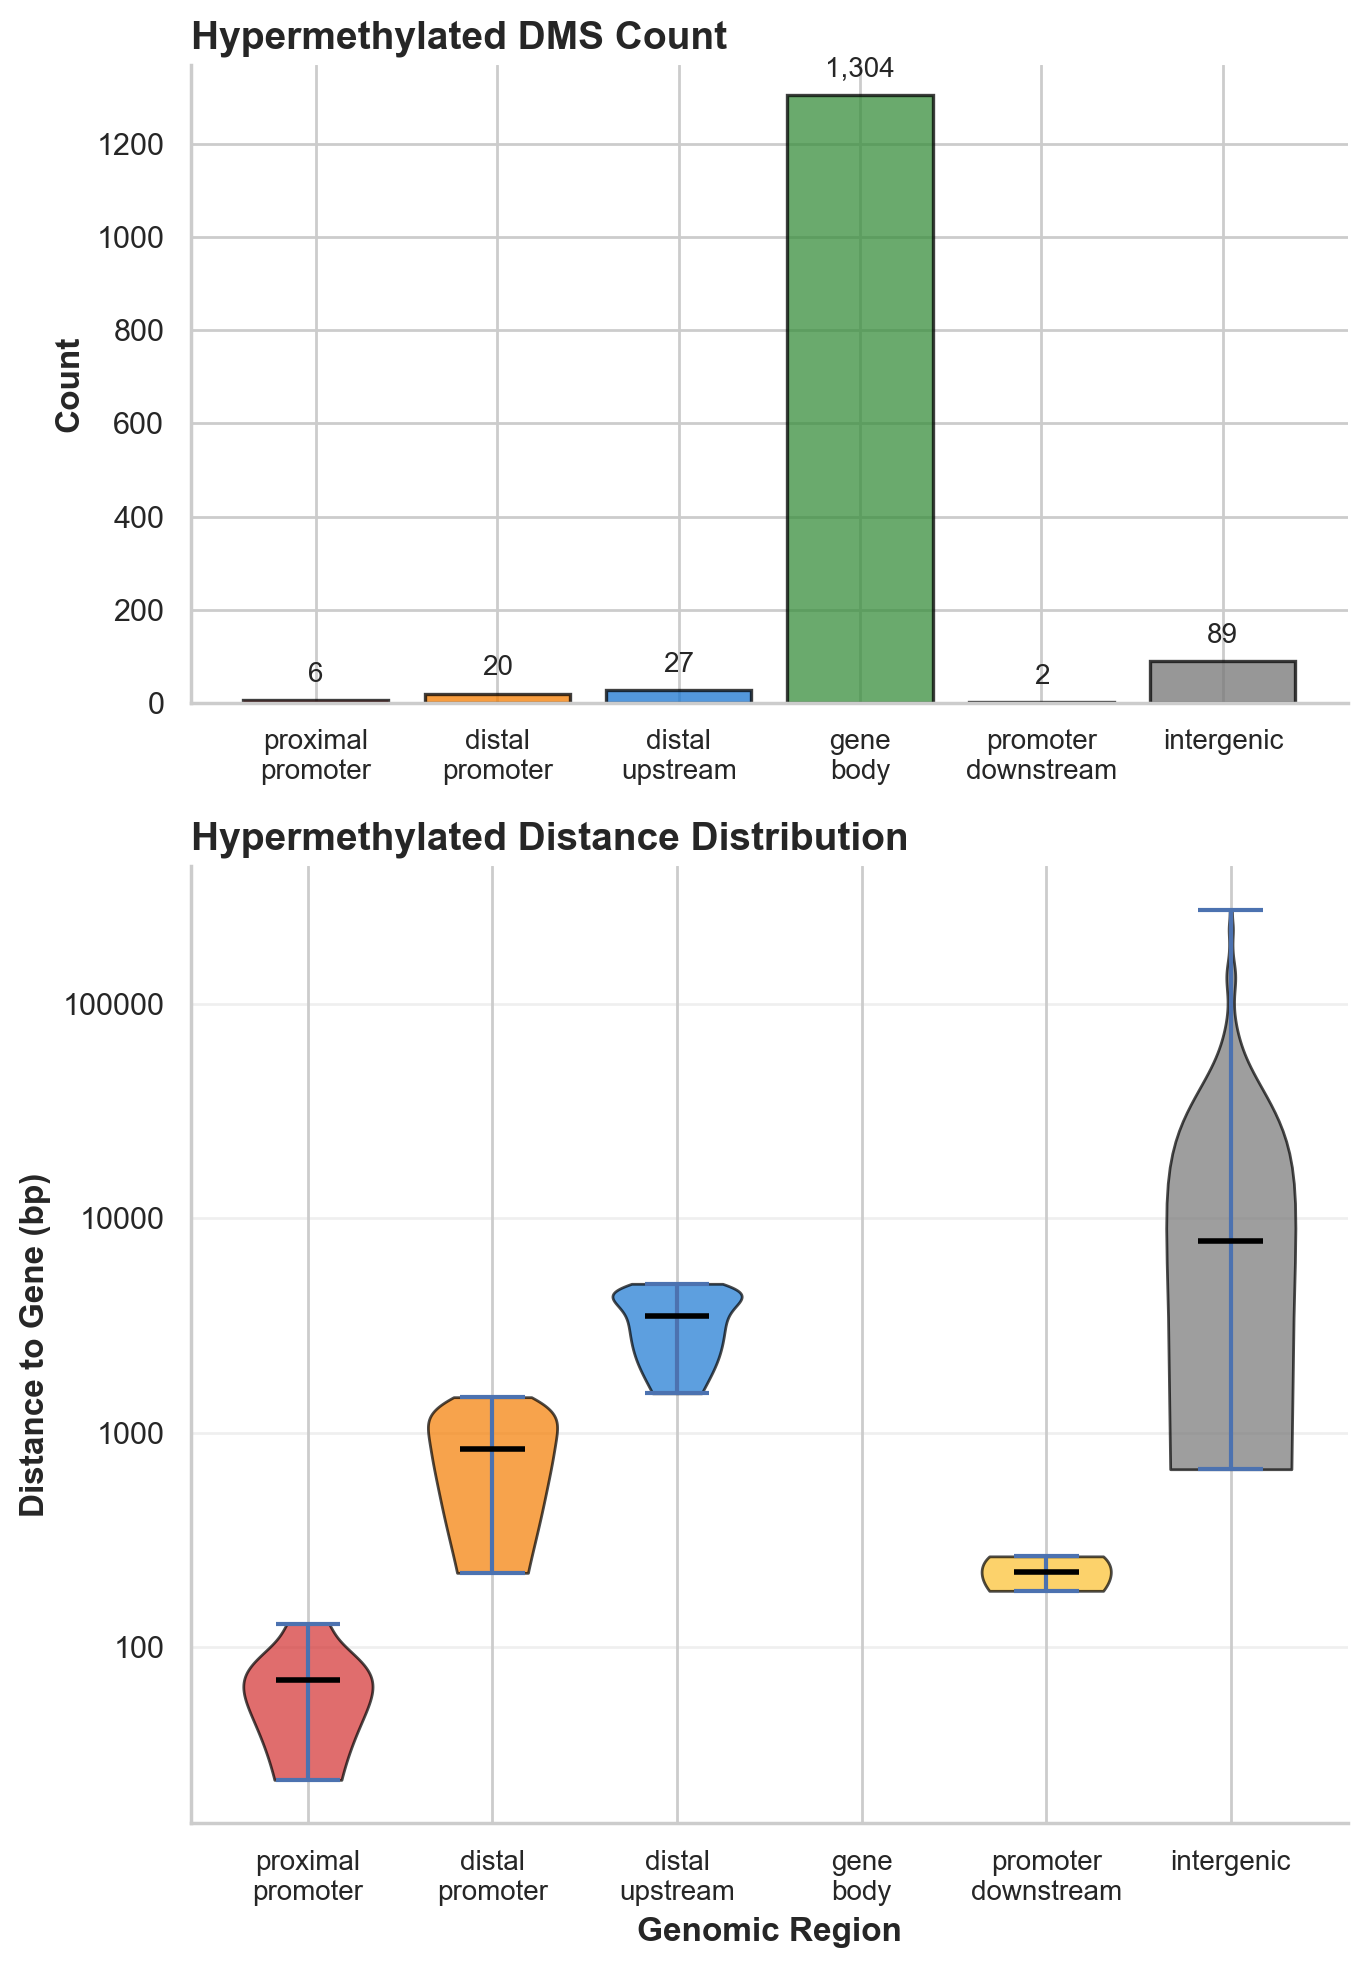

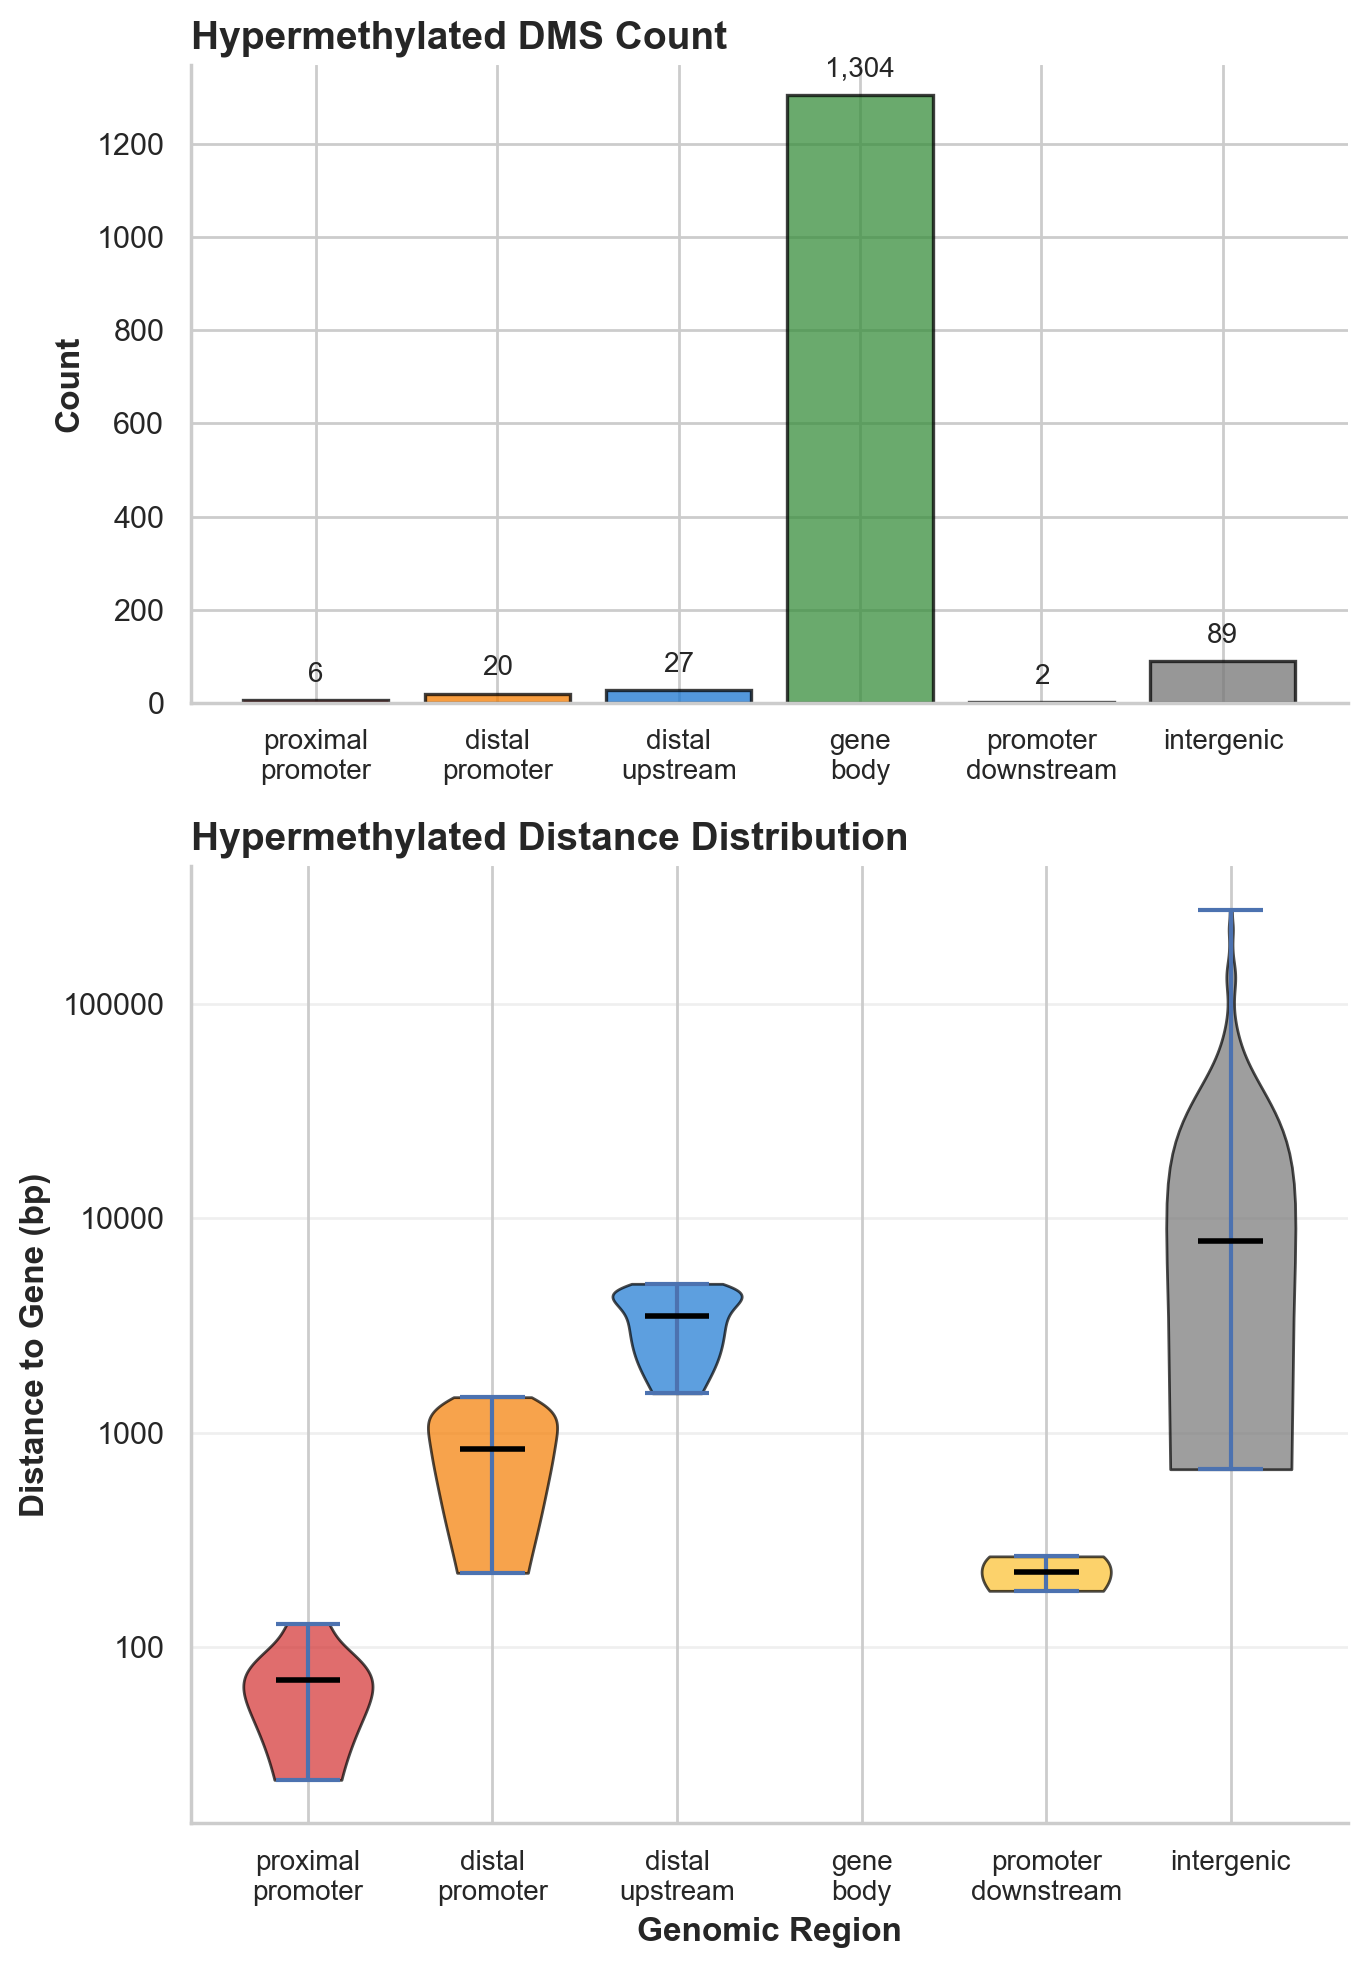

In [67]:
hypermeth_genes = sig_dms_genes[sig_dms_genes["logFC"] > 1].dropna()
fig_hyper, table_hyper = plot_dms_summary(
    hypermeth_genes, relation_order, color_map, title_prefix="Hypermethylated"
)
table_hyper
fig_hyper

##### B. Hypomethylated

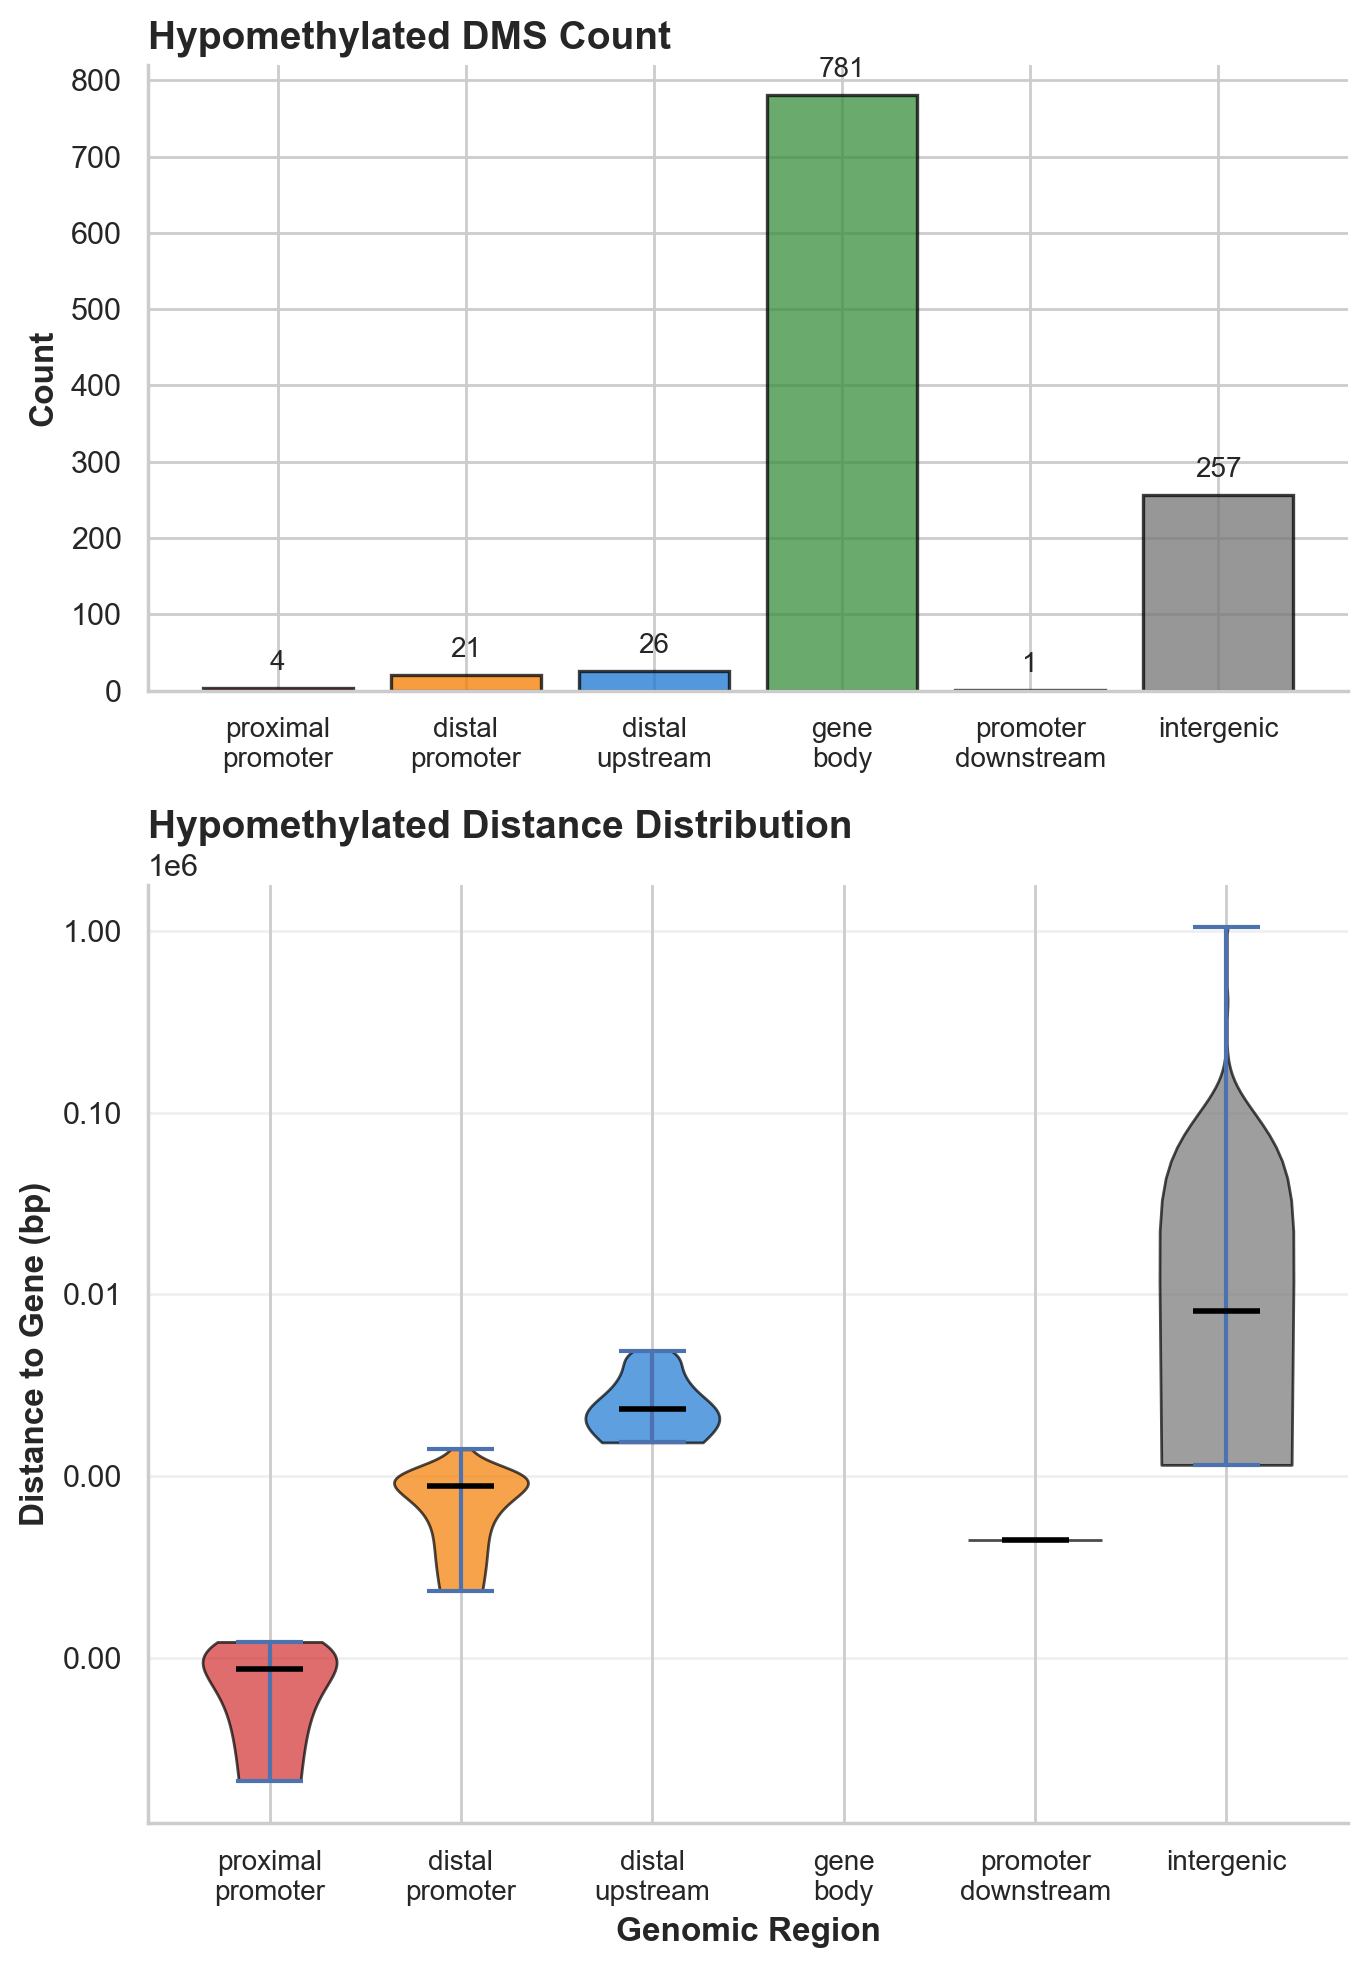

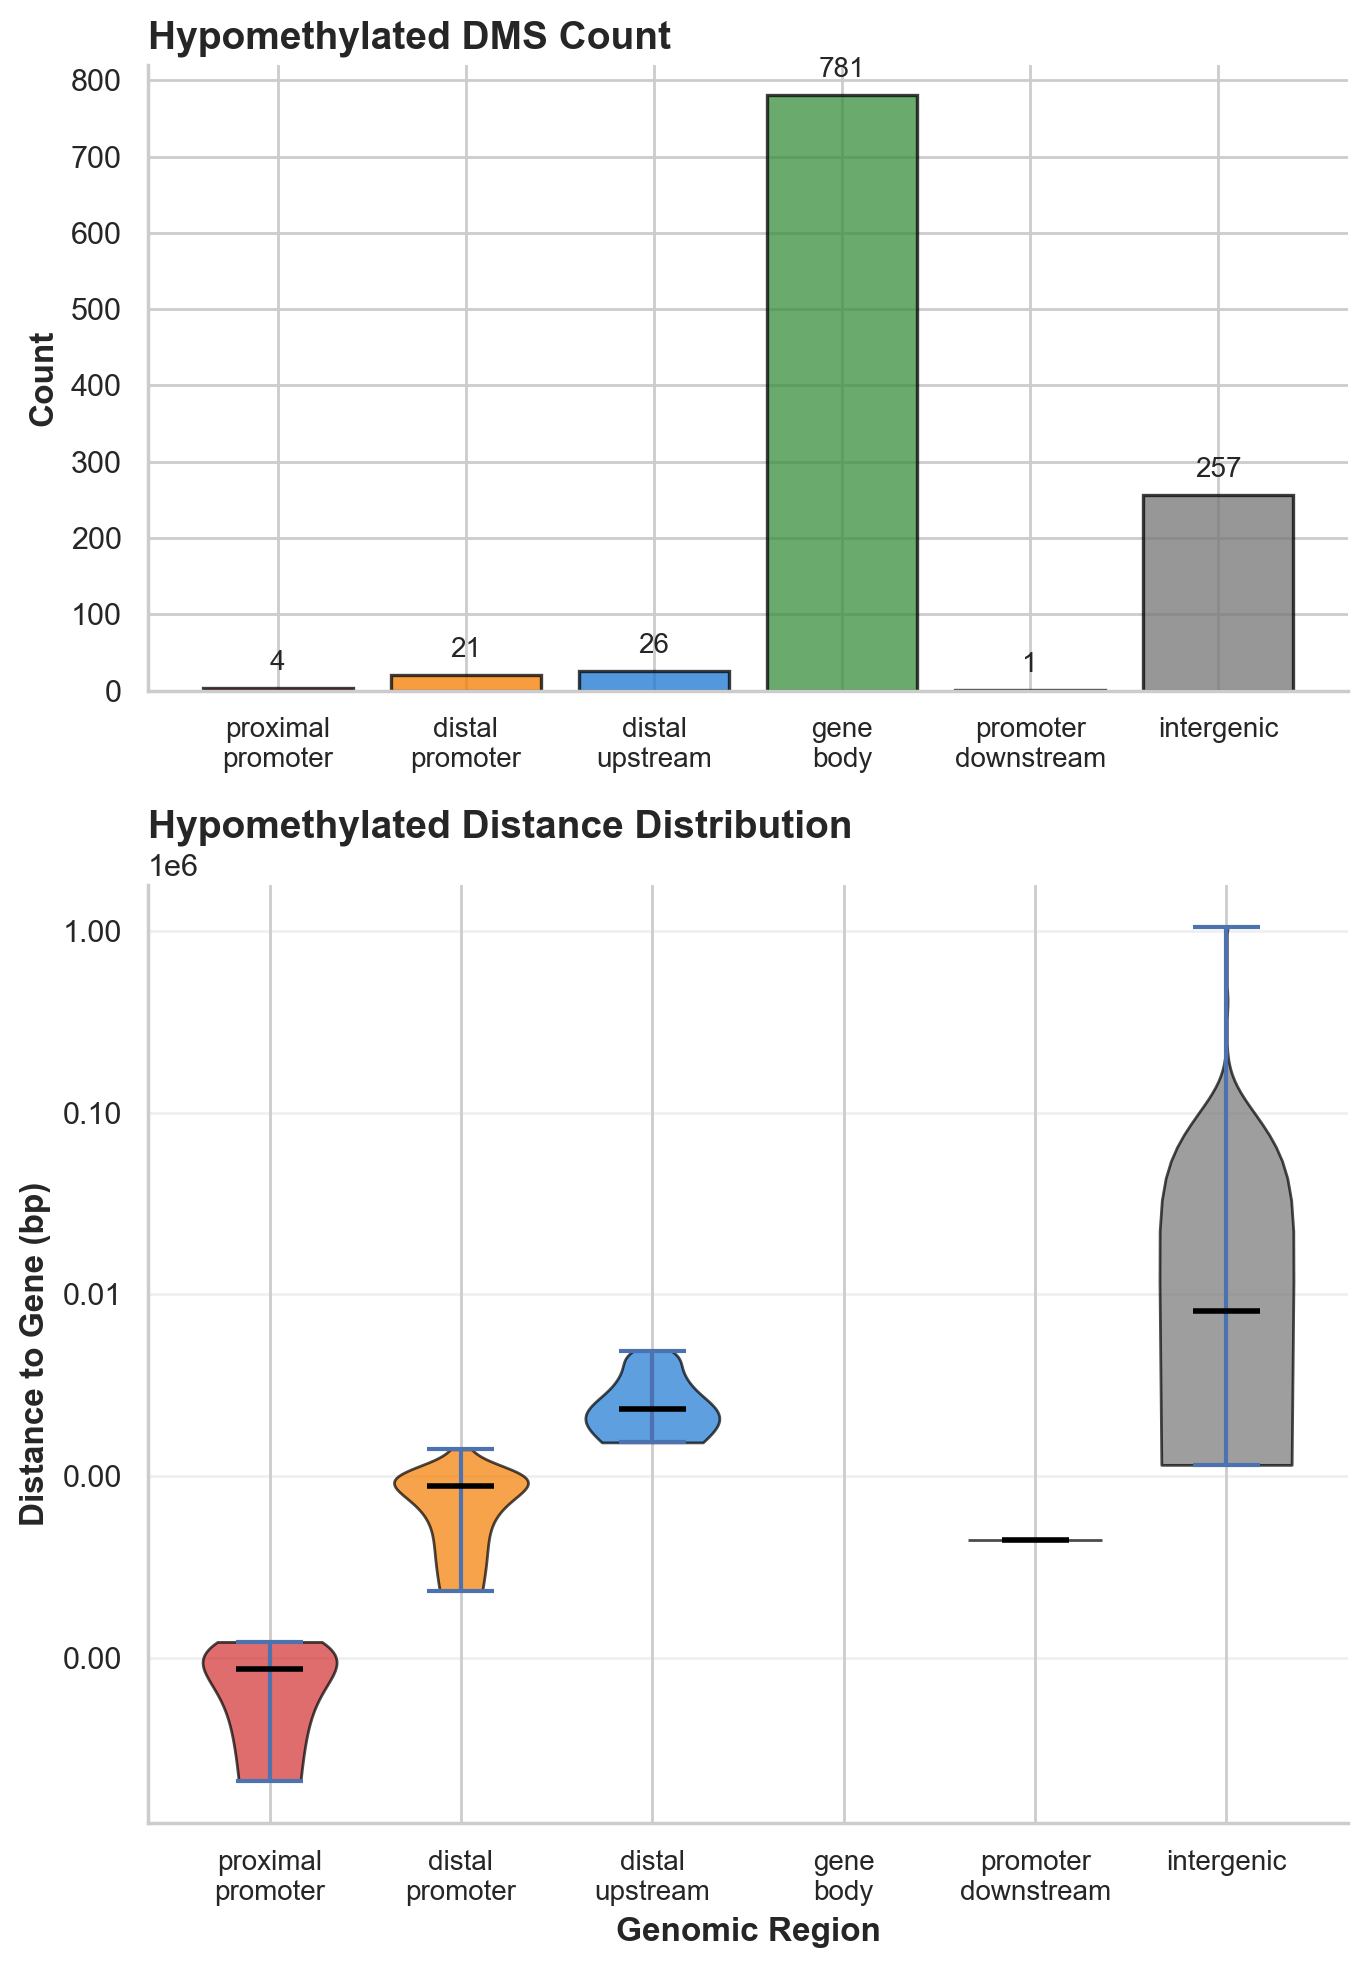

In [68]:
hypometh_genes = sig_dms_genes[sig_dms_genes["logFC"] < -1]
fig_hypo, table_hypo = plot_dms_summary(
    hypometh_genes, relation_order, color_map, title_prefix="Hypomethylated"
)
table_hypo
fig_hypo

#### 8.4 Modeling

##### 8.4.1 Signature Discovery & Modeling

This step identifies the most informative CpG sites and trains a predictive model to distinguish tumor from normal samples.

- `select_signature_panel()` selects the top CpGs ranked by effect size or importance (t statistic).
- `model_dms_for_prediction()` trains a classification model using β-values of the selected CpGs.
- A random forest is used with 5-fold cross-validation.
- Outputs include cross-validation metrics that summarize model performance.

In [69]:
top_features = select_signature_panel(res, method="top", top_n=100, importance_col="t")
beta_features = betas.loc[betas.index.intersection(top_features)]

pred = model_dms_for_prediction(
    beta=beta_features,
    labels=data.pheno["group"].map({"normal": 0, "tumor": 1}),
    method="random_forest",
    n_splits=5,
    random_state=42,
)

cv_results = pd.DataFrame(pred["cv_results"])
cv_results.index = [f"Fold {i+1}" for i in range(len(cv_results))]
cv_results.loc["Mean"] = cv_results.mean()

cv_results

fit_time  score_time  test_score  train_score
Fold 1  0.636047    0.029519         1.0          1.0
Fold 2  0.633328    0.022613         1.0          1.0
Fold 3  0.553242    0.018827         1.0          1.0
Fold 4  0.590287    0.019821         1.0          1.0
Fold 5  0.527513    0.018981         1.0          1.0
Mean    0.588084    0.021952         1.0          1.0

##### 8.4.2 Validate signature

The selected signature is then evaluated on an independent hold-out subset to assess generalization performance.

- The dataset is split into training (\~80%) and testing (~20%) partitions.
- `validate_signature()` fits an elastic net model on the training set.
- Prediction accuracy, AUC, and related metrics are computed on the test set.
- This step confirms that the signature retains predictive value on unseen samples.

In [70]:
n = beta_features.shape[1]
test_idx = beta_features.columns[
    : max(2, n // 5)
]  # even better, use StratifiedShuffleSplit() or
train_idx = beta_features.columns[max(2, n // 5) :]  # train_test_split(..., stratify=y)

validated = validate_signature(
    X_train=beta_features[train_idx].T,
    y_train=data.pheno.loc[train_idx, "group"].map({"normal": 0, "tumor": 1}),
    X_test=beta_features[test_idx].T,
    y_test=data.pheno.loc[test_idx, "group"].map({"normal": 0, "tumor": 1}),
    features=beta_features.index,
    method="elasticnet",
)
print("Validation metrics:\n\n", validated)

Validation metrics:

 {'auc': 1.0, 'accuracy': 1.0}
